<center><h1> KPMG Machine Learning Modelling Part <center><h1>

## Load Libraries for Cleaning and Modelling

In [16]:
!pip install -U imbalanced-learn

In [17]:
import sys
sys.path.append('../../')
from metrics import *

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn


# Imputing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modelling Preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold



from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Supervised
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier,
                              AdaBoostClassifier,
                              BaggingClassifier)

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import xgboost as xgb
from xgboost import XGBClassifier

import shap
shap.initjs()

# Metrics 
from sklearn.metrics import *

# For imbalance



In [22]:
#df = pd.read_excel('../../../tagged_round_one.xlsx', sheet_name = 'features_v7', header = 1)

df = pd.read_excel('./tagged_round_one.xlsx', sheet_name = 'features_v7', header = 1)

In [23]:
df.shape

(41910, 34)

#### Missing data analysis

* `line_height` is completely missing 
* `LS` has some missing values: This means that these lines do not have any LS; hence, we'll encode these to 0. 
* The rest of the missing columns are those that we made ourselves to tag the feature. We will be dropping them. 

In [24]:
df.isna().sum() 

text                         0
document                     0
Name                     31603
Section_Id_Document      41013
Section_ID               41011
Paragraph                40676
Comment                  40752
Class                    34166
df_idx                       0
class                        0
style                        0
id                           0
font-size                    0
vertical-align               0
color                        0
font-family                  0
font-weight                  0
font-style                   0
position                     0
left                         0
top                          0
document_id                  0
page                         0
line-height              41906
Num_Words                    0
String_Length                0
Leading_Char_Upper           0
Leading_Numeral              0
Ends_In_Period               0
Leading_Number_Period        0
Leading_Char_Period          0
Roman_Period                 0
Left_Px 

#### Get document count

In [25]:
num_docs = len(df.groupby('document').count()['text'].rename('Count'))
num_docs

119

#### Drop rows which are not labelled

In [26]:
df = df[df['Class'].isna()==False]

#### See how many documents are done and percentage

In [27]:
num_docs_done = len(df.groupby('document').count()['text'].rename('Count'))

In [28]:
num_docs_done / num_docs

0.31092436974789917

### Extract `first 3 words`,` 5 words`, `first word`, `last word`

In [29]:
df.sample(2)

,text,document,Name,Section_Id_Document,Section_ID,Paragraph,Comment,Class,df_idx,class,...,Num_Words,String_Length,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,Left_Px,LS
1261,"Pa. Dec. 23, 2013); S. Nazarene Univ. v. Sebel...",html_files/CMS_2014_0115_12304.pdf,gayani,NaN,NaN,NaN,NaN,0.0,192,txt,...,16,100,1,0,0,0,0,0,72,12.0
988,clshq@clsnet.org - www.clsnet.org,html_files/CMS_2014_0115_11997.pdf,gayani,NaN,NaN,0,NaN,0.0,34883,txt,...,3,33,0,0,0,0,0,0,220,12.0


In [30]:
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

In [31]:
### Convert the text column data type to string

import re

df['text'] = df['text'].apply(str)

### Three gram

df['3_grams'] = df['text'].map(lambda x: find_ngrams(x.split(" "), 3))
#df['new_col'] = df.triigrams.apply(lambda x: x[0:1])
df['first_3_words'] = df["3_grams"].str[0]
df['first_3_words'] = df['first_3_words'].apply(str)
df['first_3_words'] = df['first_3_words'].str.replace(r'[^\w\s]+', '')

### Remove stop words from first 3 wodrds

# df['first_3_words'] = df['first_3_words'].apply(lambda x: [item for item in x.split(" ") if item not in stopwords])


### Five gram

df['5_grams'] = df['text'].map(lambda x: find_ngrams(x.split(" "), 5))
df['first_5_words'] = df['5_grams'].str[0]
df['first_5_words'] = df['first_5_words'].apply(str)
df['first_5_words'] = df['first_5_words'].str.replace(r'[^\w\s]+', '')


### I will drop 3-gram and 5_gram columns and keep only fist three words and first five words columns

df = df.drop(['3_grams', '5_grams'], axis = 1)


In [32]:
### Extract first and last word

df["First_Word"] = df["text"].apply(lambda x: x.split()[0:1])
df["First_Word"] = df["First_Word"].apply(str)
df["First_Word"] = df["First_Word"].str.replace(r'[^\w\s]+', '')

df["Last_Word"] = df["text"].apply(lambda x: x.split()[-1:])
df["Last_Word"] = df["Last_Word"].apply(str)
df["Last_Word"] = df["Last_Word"].str.replace(r'[^\w\s]+', '')

#### Note: We don't need the features below since, they'll be captured in the First_Word_Feature anyway 

In [33]:
# #df['Start_conclusion'] = df['First_Word'].str.contains('Conclusion')
# df['Start_conclusion'] = (df['First_Word'].str.contains('Conclusion')) | (df['First_Word'].str.contains('CONCLUSION'))
# df['Start_conclusion'] = df['Start_conclusion'].map({True: 1, False: 0})

# df['Start_Re'] = df['First_Word'].str.contains('Re')
# df['Start_Re'] = df['Start_Re'].map({True: 1, False: 0})
                    
# df['Start_Attention'] = df['First_Word'].str.contains('Attention')
# df['Start_Attention'] = df['Start_Attention'].map({True: 1, False: 0})

In [35]:
# SAVE: Please don't ever save documents in the directory which you will push 
# since we don't want to commit our data to github
df.to_csv('../../../featuresV9.csv')

## Data Cleaning

1. Drop irrelavant columns
2. Convert columns kept to right types 

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7744 entries, 0 to 41909
Data columns (total 38 columns):
text                     7744 non-null object
document                 7744 non-null object
Name                     7744 non-null object
Section_Id_Document      897 non-null float64
Section_ID               899 non-null float64
Paragraph                1234 non-null object
Comment                  1158 non-null object
Class                    7744 non-null float64
df_idx                   7744 non-null int64
class                    7744 non-null object
style                    7744 non-null object
id                       7744 non-null object
font-size                7744 non-null object
vertical-align           7744 non-null object
color                    7744 non-null object
font-family              7744 non-null object
font-weight              7744 non-null object
font-style               7744 non-null object
position                 7744 non-null object
left              

### 1. Drop Irrelavant Columns 
* Drop text since we don't really need it and are using derived features from it 
* Drop columns that we created ourselves for tagging:
`Name`, `section Id document`, `document id`, `section id`, `Comment`, `Paragraph` are not useful since we created them for labelling or target
* `df_idx` is the same thing as document_id and document 
* We keep `document` : we will cat encdode it later 
* Remove `class` (lowercase) since it only has one value
* Drop `position` since it only has one value
* `line height` has nothing in it ... only **nans** 
* Remove `string length` since it's correlated with numwords
* Remove `Left_Px` since it's the same thing as `left` which I clean in the next section
* Remove `style` since it's the same thing as `font+vertical+align+color` which I clean in the next section
* Remove `vertical-align` since it's the same value which is `baseline`
* Remove `id` it is a same as `font-size` 

In [37]:
df = df.drop(['text', 'Name', 'Section_Id_Document', 'document_id',
             'Section_ID', 'Comment', 'Paragraph', 'df_idx' , 'class', 'position',
              'page', 'line-height', 'String_Length', 'Left_Px','style','vertical-align'], axis = 1)

Columns that I may remove later:
- `page`: Not sure if it's relevant at all
- `color`: Need to clean it but may not give any feature importance


### 2. Clean columns:  `font_weight`,`font_style`,`fontsize`, `left` and `top`: 

- Change font_weight and font_size to binary
- Remove px and 
- Convert to right data typ

In [38]:
df['font-weight'] = df['font-weight'].map({'bold': 1, 'normal': 0})
df['font-style'] = df['font-style'].map({'italic': 1, 'normal': 0})

df['font-size'] = df['font-size'].str.replace('px', '')
df['font-size'] = pd.to_numeric(df['font-size'])

df['left'] = df['left'].str.replace('px', '')
df['left'] = pd.to_numeric(df['left'])

df['top'] = df['top'].str.replace('px', '')
df['top'] = pd.to_numeric(df['top'])

#### Chage the data type from `int` to `float`

In [39]:
# 'Start_conclusion','Start_Re','Start_Attention'

cols = ['font-weight', 'font-style', 'left', 'top','Num_Words','Leading_Char_Upper','Leading_Numeral','Ends_In_Period','Leading_Number_Period','Leading_Char_Period','Roman_Period']
for col in cols:
    df[col] = df[col].apply(lambda x: float(x))

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7744 entries, 0 to 41909
Data columns (total 22 columns):
document                 7744 non-null object
Class                    7744 non-null float64
id                       7744 non-null object
font-size                7744 non-null int64
color                    7744 non-null object
font-family              7744 non-null object
font-weight              7744 non-null float64
font-style               7744 non-null float64
left                     7744 non-null float64
top                      7744 non-null float64
Num_Words                7744 non-null float64
Leading_Char_Upper       7744 non-null float64
Leading_Numeral          7744 non-null float64
Ends_In_Period           7744 non-null float64
Leading_Number_Period    7744 non-null float64
Leading_Char_Period      7744 non-null float64
Roman_Period             7744 non-null float64
LS                       7527 non-null float64
first_3_words            7744 non-null object
first_

In [41]:
df.to_csv('../../../featuresV10.csv')

#### Impute Missing Column: LS


In [42]:
df['LS'] = df['LS'].fillna(0)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7744 entries, 0 to 41909
Data columns (total 22 columns):
document                 7744 non-null object
Class                    7744 non-null float64
id                       7744 non-null object
font-size                7744 non-null int64
color                    7744 non-null object
font-family              7744 non-null object
font-weight              7744 non-null float64
font-style               7744 non-null float64
left                     7744 non-null float64
top                      7744 non-null float64
Num_Words                7744 non-null float64
Leading_Char_Upper       7744 non-null float64
Leading_Numeral          7744 non-null float64
Ends_In_Period           7744 non-null float64
Leading_Number_Period    7744 non-null float64
Leading_Char_Period      7744 non-null float64
Roman_Period             7744 non-null float64
LS                       7744 non-null float64
first_3_words            7744 non-null object
first_

## Modelling
#### Part I: Data Cleaning and Preparation
1. Separate Target and Data
2. Split into Test and Train
3. Clean Numeric Features 
4. Clean Categorical Features
4. Try NLP Techniques
6. Combine Data Frames

#### Part II: Models
1. Logistic Regression
2. Random Forest
4. Playing with Evaluation Metrics
5. Boosting: AdaBoost and Gradient Boosting
6. Boosting: XGBoost

#### Part III: Pipeline and Tune
1. Parameter Tuning on the Best Model with Pipeline 
2. Change Thresholds
3. Evaluate on Test Set

### Part 1: Prepare

#### 1. Separate Target and Features 

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7744 entries, 0 to 41909
Data columns (total 22 columns):
document                 7744 non-null object
Class                    7744 non-null float64
id                       7744 non-null object
font-size                7744 non-null int64
color                    7744 non-null object
font-family              7744 non-null object
font-weight              7744 non-null float64
font-style               7744 non-null float64
left                     7744 non-null float64
top                      7744 non-null float64
Num_Words                7744 non-null float64
Leading_Char_Upper       7744 non-null float64
Leading_Numeral          7744 non-null float64
Ends_In_Period           7744 non-null float64
Leading_Number_Period    7744 non-null float64
Leading_Char_Period      7744 non-null float64
Roman_Period             7744 non-null float64
LS                       7744 non-null float64
first_3_words            7744 non-null object
first_

In [45]:
df.shape

(7744, 22)

In [46]:
X = df.drop(['Class'], axis = 1)

y = df['Class']

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7744 entries, 0 to 41909
Data columns (total 21 columns):
document                 7744 non-null object
id                       7744 non-null object
font-size                7744 non-null int64
color                    7744 non-null object
font-family              7744 non-null object
font-weight              7744 non-null float64
font-style               7744 non-null float64
left                     7744 non-null float64
top                      7744 non-null float64
Num_Words                7744 non-null float64
Leading_Char_Upper       7744 non-null float64
Leading_Numeral          7744 non-null float64
Ends_In_Period           7744 non-null float64
Leading_Number_Period    7744 non-null float64
Leading_Char_Period      7744 non-null float64
Roman_Period             7744 non-null float64
LS                       7744 non-null float64
first_3_words            7744 non-null object
first_5_words            7744 non-null object
First_W

In [48]:
X.shape

(7744, 21)

#### Check out imbalance

In [49]:
imbalance = (len(y[y == 1]) / len(y)) * 100
print('Class Imblance: {:.2f}%'.format(imbalance))

Class Imblance: 1.89%


0.0    7598
1.0     146
Name: Class, dtype: int64

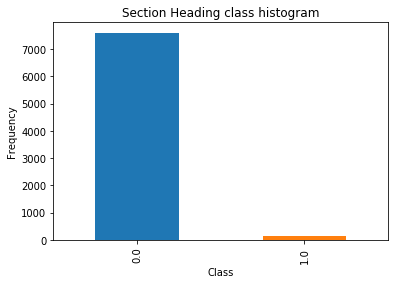

In [53]:
pd.value_counts(y).plot.bar()
plt.title('Section Heading class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
df['Class'].value_counts()

#### 2. Train Test Split

In [54]:
# 30% will be selected for testing data randomly
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.30,
                                                    shuffle = True,
                                                    random_state = 9834) 

#### 3. Clean up Numeric features 

In [55]:
X_train_num = X_train.select_dtypes(exclude="object")

In [57]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5420 entries, 3226 to 5064
Data columns (total 13 columns):
font-size                5420 non-null int64
font-weight              5420 non-null float64
font-style               5420 non-null float64
left                     5420 non-null float64
top                      5420 non-null float64
Num_Words                5420 non-null float64
Leading_Char_Upper       5420 non-null float64
Leading_Numeral          5420 non-null float64
Ends_In_Period           5420 non-null float64
Leading_Number_Period    5420 non-null float64
Leading_Char_Period      5420 non-null float64
Roman_Period             5420 non-null float64
LS                       5420 non-null float64
dtypes: float64(12), int64(1)
memory usage: 592.8 KB


In [58]:
X_train_num.sample(3)

,font-size,font-weight,font-style,left,top,Num_Words,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,LS
2776,9,0.0,0.0,72.0,661.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0
40888,10,0.0,0.0,67.0,277.0,26.0,1.0,0.0,0.0,0.0,0.0,0.0,27.0
635,33,0.0,0.0,206.0,1455.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0


#### Split into binary and continuous

In [59]:
X_train_cont = X_train_num[['font-size', 'left', 'top', 'Num_Words', 'LS']]

In [60]:
X_train_binary = X_train_num[['font-weight', 'font-style', 'Leading_Char_Upper',
                'Leading_Numeral', 'Ends_In_Period', 'Leading_Number_Period',
                'Leading_Char_Period', 'Roman_Period']]

In [61]:
print(X_train_cont.shape)
print(X_train_binary.shape)
print(X_train_num.shape)

(5420, 5)
(5420, 8)
(5420, 13)


#### Impute Missing Column: LS: SHOULD NOT IMPUTE HERE; IMPUTE IN PIPELINE 
LS has some missing values: This means that these lines do not have any LS; hence, we'll encode these to 0.

In [62]:
X_train_cont['LS'] = X_train_cont['LS'].fillna(0)

C:\Users\Gayani\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
X_train_cont.isna().sum() 

font-size    0
left         0
top          0
Num_Words    0
LS           0
dtype: int64

#### Combine DFs to get X_Numeric

In [64]:
X_train_num = pd.concat([X_train_cont, X_train_binary], axis = 1)

#### 4. Clean up Non-Numeric features

In [65]:
X_train_cat = X_train.select_dtypes(include="object")

In [66]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5420 entries, 3226 to 5064
Data columns (total 8 columns):
document         5420 non-null object
id               5420 non-null object
color            5420 non-null object
font-family      5420 non-null object
first_3_words    5420 non-null object
first_5_words    5420 non-null object
First_Word       5420 non-null object
Last_Word        5420 non-null object
dtypes: object(8)
memory usage: 381.1+ KB


In [67]:
X_train_cat.sample(3)

,document,id,color,font-family,first_3_words,first_5_words,First_Word,Last_Word
974,html_files/CMS_2014_0115_11997.pdf,f1,"rgba(0,0,0,1)",serif,we must consult,we must consult in determining,we,the
3036,html_files/CMS_2014_0115_12895.pdf,f1,"rgba(0,0,0,1)",serif,established or maintained,established or maintained by an,established,an
1237,html_files/CMS_2014_0115_12304.pdf,f4,"rgba(0,0,0,1)",sans-serif,beliefs by involving,beliefs by involving them in,beliefs,The


In [68]:
X_train_text = X_train_cat[['first_3_words', 'first_5_words', 
                'First_Word', 'Last_Word']] # 'Start_Introduction', 'Start_conclusion'

In [69]:
X_train_non_text = X_train_cat[['document', 'color', 'font-family']]

In [70]:
print(X_train_text.shape)
print(X_train_non_text.shape)
print(X_train_cat.shape)

(5420, 4)
(5420, 3)
(5420, 8)


#### OneHotEncode `First Word` Column

In [71]:
one_hot_first_word = pd.get_dummies(X_train_text['First_Word'])

In [72]:
one_hot_first_word.shape

(5420, 2095)

#### OneHotEncode `Last Word` Column

In [73]:
one_hot_last_word = pd.get_dummies(X_train_text['Last_Word'])

In [74]:
one_hot_last_word.shape

(5420, 1986)

#### OneHotEncode Non-Text Columns

In [75]:
sum = 0
for col in X_train_non_text:
    print(len(X_train_non_text[col].unique()))
    sum += len(X_train_non_text[col].unique())
print("Sum =",sum) 

36
18
2
Sum = 56


In [76]:
X_train_non_text = pd.get_dummies(X_train_non_text)

In [77]:
X_train_non_text.shape

(5420, 56)

### NLP Techniques: Get Bag of Words

In [78]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

In [79]:
first_3_words = X_train_text['first_3_words']

In [80]:
vect_first_3 = CountVectorizer(stop_words='english', ngram_range=(1, 2)).fit(first_3_words)
bag_of_words_first_3 = vect_first_3.transform(first_3_words)

In [81]:
sdf_3 = pd.SparseDataFrame(bag_of_words_first_3,
                         columns=vect_first_3.get_feature_names(), 
                         default_fill_value=0)

In [82]:
first_5_words = X_train_text['first_5_words']

In [83]:
vect_first_5 = CountVectorizer(stop_words='english', ngram_range=(1, 2)).fit(first_5_words)
bag_of_words_first_5 = vect_first_5.transform(first_5_words)

In [84]:
sdf_5 = pd.SparseDataFrame(bag_of_words_first_5,
                         columns=vect_first_5.get_feature_names(), 
                         default_fill_value=0)

#### Stop Words + Ngrams

In [85]:
CountVectorizer(stop_words='english', ngram_range=(1, 2))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [86]:
TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

#### 5. Combine Data Frames

#### Categorical Data: 
1. Keep all non-text columns: OneHotEncoded
2. Create 3 versions:
    * First word
    * First 3 words
    * First 5 words 
 



In [87]:
# reset index for all
X_train_non_text.reset_index(inplace = True)
one_hot_first_word.reset_index(inplace = True)
one_hot_last_word.reset_index(inplace = True)

sdf_3.reset_index(inplace = True)
sdf_5.reset_index(inplace = True)

In [88]:
X_train_cat_1 = pd.concat([X_train_non_text, one_hot_first_word, one_hot_last_word], axis = 1)

In [89]:
X_train_cat_1.head()

,index,document_html_files/CMS_2014_0115_0059.pdf,document_html_files/CMS_2014_0115_0076.pdf,document_html_files/CMS_2014_0115_10379.pdf,document_html_files/CMS_2014_0115_10593.pdf,document_html_files/CMS_2014_0115_11997.pdf,document_html_files/CMS_2014_0115_12304.pdf,document_html_files/CMS_2014_0115_12451.pdf,document_html_files/CMS_2014_0115_12505.pdf,document_html_files/CMS_2014_0115_12528.pdf,...,wwwnyemastercom,wwwpcmanetorg,wwwregulationsgov,wwwwvfroeorg,y,year,yet,you,young,yours
0,3226,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4594,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6594,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,590,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6323,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
print(X_train_non_text.shape)
print(one_hot_first_word.shape)
print(X_train_cat_1.shape)

(5420, 57)
(5420, 2096)
(5420, 4140)


In [91]:
# drop index
X_train_cat_1.drop(['index'], axis = 1, inplace = True)

In [92]:
print(X_train_cat_1.shape)

(5420, 4137)


In [93]:
X_train_cat_2 = pd.concat([X_train_non_text, sdf_3, one_hot_last_word], axis = 1)

In [94]:
print(X_train_non_text.shape)
print(sdf_3.shape)
print(X_train_cat_2.shape)

(5420, 57)
(5420, 6371)
(5420, 8415)


In [95]:
# drop index
X_train_cat_2.drop(['index'], axis = 1, inplace = True)

In [96]:
print(X_train_cat_2.shape)

(5420, 8412)


In [97]:
X_train_cat_3 = pd.concat([X_train_non_text, sdf_5, one_hot_last_word], axis = 1)

In [98]:
print(X_train_non_text.shape)
print(sdf_5.shape)
print(X_train_cat_3.shape)

(5420, 57)
(5420, 10760)
(5420, 12804)


In [99]:
# drop index
X_train_cat_3.drop(['index'], axis = 1, inplace = True)

In [100]:
print(X_train_cat_3.shape)

(5420, 12801)


#### Target-based Encoding to reduce dimensions created by OneHotEncoding

#### Combine Numerical and Categorical

In [101]:
# reset index for all
X_train_num.reset_index(inplace = True)
X_train_cat_1.reset_index(inplace = True)
X_train_cat_2.reset_index(inplace = True)
X_train_cat_3.reset_index(inplace = True)

In [102]:
X_train = pd.concat([X_train_num, X_train_cat_2], axis = 1)

In [103]:
print(X_train_num.shape)
print(X_train_cat_1.shape)
print(X_train.shape)

(5420, 14)
(5420, 4138)
(5420, 8427)


In [104]:
# drop index
X_train.drop(['index'], axis = 1, inplace = True)

In [105]:
print(X_train.shape)

(5420, 8425)


### Part 2: Models

### 1. Logistic Regression

#### 1.1: L2 Penalty

#### Look at cross-validated performance

In [78]:
lr_scores = cross_val_score(LogisticRegression(), 
                        X_train, y_train, 
                        cv = 5,
                        scoring= 'roc_auc') # cross validation
lr_mean_score = np.mean(lr_scores)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

In [85]:
lr_mean_score

0.980795444632277

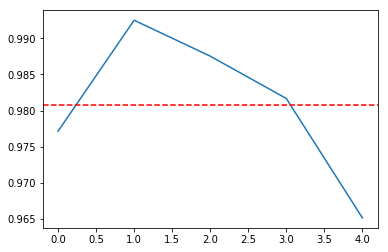

In [86]:
plt.plot(lr_scores)
plt.axhline(lr_mean_score, color='r', linestyle='--') # plot mean line 
plt.show()

#### Fit one model

In [93]:
lr = LogisticRegression(penalty = 'l2', 
                        C = 1, 
                        class_weight = 'balanced', 
                        solver = 'sag', 
                        max_iter = 100, 
                        random_state = 4896) 
lr.fit(X_train, y_train)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=4896,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)

In [94]:
y_pred = lr.predict(X_train)

#### Model Performance

In [162]:
def metrics(y, pred):
    print("Accuracy score: {:.2f}".format(accuracy_score(y, pred)))
    print("F1 score: {:.2f}".format(f1_score(y, pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y, pred)))

In [96]:
metrics(y_train, y_pred)

Accuracy score: 0.81
F1 score: 0.13
ROC AUC score: 0.80


In [163]:
def confusion_metrics(y, pred):
    cm = confusion_matrix(y, pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])
    print(" ")
    print("Other Metrics:")
    print(" ")
    print("Precision %.2f" % (cm[1][1] / (cm[1][1] + cm[0][1])))
    print("Recall / True Positive Rate %.2f" % (cm[1][1] / (cm[1][1] + cm[1][0])))   
    print("True Negative Rate: %.2f" % (cm[0][0] / (cm[0][0] + cm[0][1])))   

In [98]:
confusion_metrics(y_train, y_pred)

True Negatives: 4298
False Negatives: 22
True Positives: 79
False Positives: 1021
 
Other Metrics:
 
Precision 0.07
Recall / True Positive Rate 0.78
True Negative Rate: 0.81


#### Look at the Important Features

In [99]:
def plot_top_k_feature_importances(coefs, k):    
    # sort 
    args = abs(coefs).argsort()[::-1][:k]    
    # get coefs 
    top_k_coefs = coefs[args]    
    # get column names
    colnames = list(X_train.columns.values[args])
    # plot 
    plt.barh(range(k), top_k_coefs, align='center') 
    plt.yticks(np.arange(k), colnames) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, k)
    plt.show()

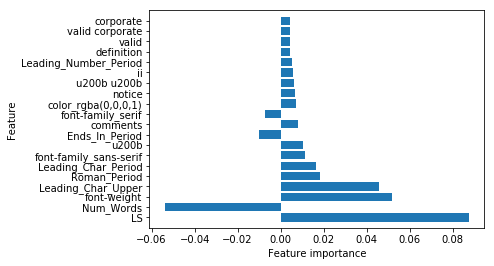

In [100]:
plot_top_k_feature_importances(lr.coef_[0], 20)

#### 1.2: L1 Penalty

In [91]:
lr = LogisticRegression(penalty = 'l1', 
                        C = 1, 
                        class_weight = 'balanced', 
                        # solver = 'sag', 
                        max_iter = 100, 
                        random_state = 4896) 
lr.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=4896,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [92]:
y_pred = lr.predict(X_train)

In [93]:
metrics(y_train, y_pred)

Accuracy score: 0.99
F1 score: 0.74
ROC AUC score: 0.99


In [94]:
confusion_metrics(y_train, y_pred)

True Negatives: 5248
False Negatives: 0
True Positives: 101
False Positives: 71
 
Other Metrics:
 
Precision 0.59
Recall / True Positive Rate 1.00
True Negative Rate: 0.99


#### Look at the Important Features

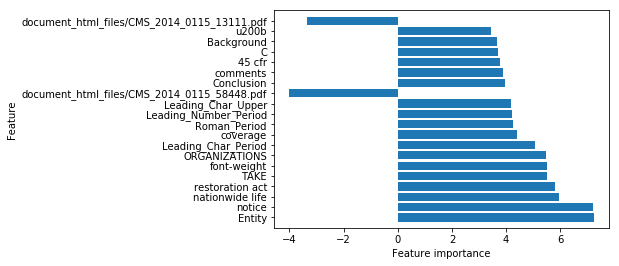

In [95]:
plot_top_k_feature_importances(lr.coef_[0], 20)

### 3. Random Forest

In [101]:
rf = RandomForestClassifier(class_weight = 'balanced') 
rf.fit(X_train, y_train)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [102]:
y_pred = rf.predict(X_train)

#### Model Performance

In [103]:
metrics(y_train, y_pred)

Accuracy score: 1.00
F1 score: 0.95
ROC AUC score: 0.96


In [104]:
confusion_metrics(y_train, y_pred)

True Negatives: 5318
False Negatives: 9
True Positives: 92
False Positives: 1
 
Other Metrics:
 
Precision 0.99
Recall / True Positive Rate 0.91
True Negative Rate: 1.00


#### Look at the Important Features

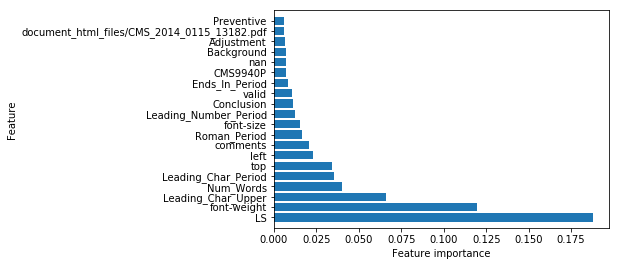

In [105]:
plot_top_k_feature_importances(rf.feature_importances_, 20)

### 5. Boosting: Adaboost

In [106]:
ab = AdaBoostClassifier() 
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [102]:
y_pred = ab.predict(X_train)

#### Model Performance

In [103]:
metrics(y_train, y_pred)

Accuracy score: 0.99
F1 score: 0.82
ROC AUC score: 0.87


In [104]:
confusion_metrics(y_train, y_pred)

True Negatives: 5313
False Negatives: 27
True Positives: 74
False Positives: 6
 
Other Metrics:
 
Precision 0.93
Recall / True Positive Rate 0.73
True Negative Rate: 1.00


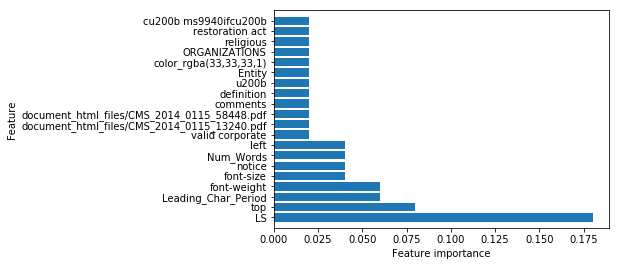

In [105]:
plot_top_k_feature_importances(ab.feature_importances_, 20)

### 5. Boosting: Gradient Boosting

In [106]:
gb = GradientBoostingClassifier() 
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [107]:
y_pred = gb.predict(X_train)

In [108]:
metrics(y_train, y_pred)

Accuracy score: 1.00
F1 score: 0.95
ROC AUC score: 0.96


In [109]:
confusion_metrics(y_train, y_pred)

True Negatives: 5317
False Negatives: 8
True Positives: 93
False Positives: 2
 
Other Metrics:
 
Precision 0.98
Recall / True Positive Rate 0.92
True Negative Rate: 1.00


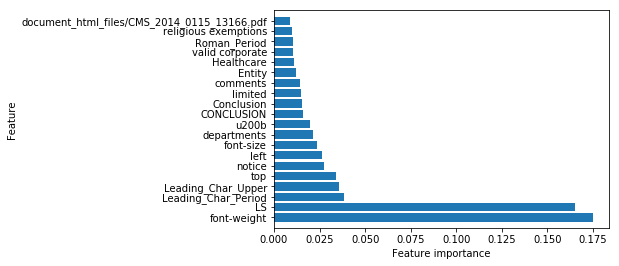

In [110]:
plot_top_k_feature_importances(gb.feature_importances_, 20)

### 6. XGBoost

In [111]:
X.shape

(7744, 20)

In [112]:
y.shape

(7744,)

In [113]:
X_train.shape

(5420, 8425)

In [114]:
clf = XGBClassifier(max_depth = 7,
                            eta = 0.05,    
                            learning_rate = 0.01,
                            n_estimators = 500,
                            objective = 'binary:logistic',
                            gamma = 0,
                            reg_alpha = 0,
                            reg_lambda = 0,
                            scale_pos_weight = 1,
                            seed = 9672,
                            missing = None)

In [115]:
clf.fit(X_train, y_train, verbose=True)
# ,
#         eval_set=[(X_test_encoded, y_test)], early_stopping_rounds=100

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields 0938as50, 10, 10 45, 10 additional, 10 brief, 10 burwell, 10 coverage, 10 grant, 10 id, 10 pace, 1020, 1020 19th, 10th, 10th cir, 10u200b, 10u200b iu200b, 10u200b u200bblacku200b, 10u200b u200byearsu200b, 11, 11 civil, 11 costs, 11 coverage, 11 hobby, 11 id, 11 national, 11 natl, 11 presumably, 11009u200b, 11009u200b bu200b, 1100u200b, 1104, 1104 2005, 11042, 111, 1118, 113, 113cv01210, 113cv01210 nd, 115, 115 billion, 115 jan, 1171, 1171 ill, 1174u200b, 1174u200b u200b117980u200b, 12, 12 134, 12 20, 12 andrews, 12 birth, 12 id, 12 sundhedsloven, 125, 125 broad, 1275, 1275 pennsylvania, 12866, 13, 13 13, 13 79, 13 caroline, 13 contraception, 13 coverage, 13 group, 13 hobby, 13 id, 13 newman, 13 personnel, 1301, 1301 street, 1310, 1310 street, 133, 134, 1379, 1379 2015, 1396u2b3, 13pdf, 13pdf visited, 14, 14 bob, 14 burwell, 14 cutter, 14 id, 14 jm, 14 kristina, 14 national, 14 physician, 147, 147130a1iv, 147130a1iv account, 147131, 147131 exemption, 1486u200b, 1486u200b u200b, 14u200b, 14u200b hu200b, 15, 15 79, 15 82, 15 elizabeth, 15 id, 15 states, 150, 152, 152 million, 1534, 15th, 15th st, 15th street, 15u200b, 15u200b au200b, 16, 16 adara, 16 example, 16 id, 16u200b, 16u200b bu200b, 17, 17 caroline, 17 eo, 17 id, 17 piggie, 17745, 17745 ilcs, 1776, 1776 massachusetts, 178, 179318, 179318 nd, 17u200b, 17u200b u200bmeaghanu200b, 18, 18 brittany, 18 disagree, 18 la, 18 motor, 18023c2, 18023c2 aca, 1875, 1875 eye, 18u200b, 18u200b u200bsu200b, 19, 19 2011, 19 burwell, 19 hobby, 19 id, 19 pichon, 19 sexual, 19 wheaton, 190119, 1973, 1976, 1976 roanoke, 1980s, 1986, 1987, 1993, 1993 hereinafter, 1995, 1996, 1996 president, 1998u200b, 1998u200b u200b, 1999, 1999 likewise, 1999 missouri, 19th, 19th street, 19u200b, 19u200b u200bnationalu200b, 1u200b, 1u200b u200bperryundemu200b, 20, 20 2012, 20 2013, 20 id, 20 usc, 200, 200 constitution, 200 independence, 20002, 20004, 20005, 2000bb, 2000bb1b2, 2000bbb1, 2000bbb1 emphasis, 20017, 20036, 2004, 2005, 2005 provides, 201, 201 maryland, 2010, 2010 aca, 2010 congress, 2011, 2011 comment, 2012, 2012 consolidated, 2012 wl, 2013, 2013 final, 2013 reaching, 2013 retrieved, 2014, 2014 79, 2014 dr, 2014 emphasis, 2014 fdas, 2014 httpwwwnytimescom20140914opinionsundaybeyondmarriagehtml_r0, 2014 issues, 2014 party, 2014 protected, 2014 submit, 2014 wheaton, 20141, 2015, 2016, 2016 21, 2017, 2017u200b, 2017u200b u200batu200b, 20201, 20210, 2022964012, 2026679070, 2026679070 email, 2027, 2027 massachusetts, 205, 20u200b, 20u200b gu200b, 21, 21 id, 21 majority, 21224, 21244, 212441850, 212448016, 21exhibit, 21u200b, 21u200b tu200b, 22, 22 appellees, 22 comment, 22 coverage, 22 id, 22314, 22u200b, 22u200b u200bctrsu200b, 23, 23 center, 23 hobby, 23 pub, 23 rr, 2318, 2318 road, 23u200b, 23u200b u200bguttmacheru200b, 24, 24 id, 24u200b, 24u200b cu200b, 25, 25 corte, 25 coverage, 25 id, 2590, 2590 45, 25u200b, 25u200b u200bacogu200b, 26, 26 42, 26 depending, 26 hobby, 26 id, 26 usc, 27, 27 133, 27 2013, 27 2014, 27 20141, 27 id, 2713, 2751, 2769, 2769 2014, 2775, 2775 hobby, 27u200b, 27u200b u200bmeghanu200b, 28, 28 brief, 28 coverage, 28 daniel, 28 employee, 28 id, 28 interrupção, 28 usc, 280311, 28u200b, 28u200b u200brachelu200b, 29, 29 health, 29 mo, 29 special, 29 taxpayer, 2969, 2996fb, 2d, 2d cir, 2u200b, 2u200b u200bamericanu200b, 30, 30 2012, 30 civil, 30 concept, 30 den, 30 mo, 300a7, 300gg22b2ci, 300gg22b2ci cong, 30dayu200b, 30dayu200b wu200b, 30u200b, 30u200b u200bseeu200b, 31, 31 education, 31 mechanism, 31 world, 312, 312 280311, 31u200b, 31u200b u200bschindleru200b, 32, 32 certain, 32 planned, 3211, 3211 fourth, 32u200b, 32u200b u200begu200b, 33, 33 appellees, 33 european, 33 id, 33 world, 34, 34 ella, 34 id, 34u200b, 34u200b lu200b, 35, 356_amcu_dflaauthcheckdampdf, 356_amcu_dflaauthcheckdampdf visited, 356_bsac_christian_legal_socpdf, 356_bsac_christian_legal_socpdf visited, 35see, 35see transcript, 35u200b, 35u200b u200baminou200b, 36, 36 term, 37, 37 id, 37 plan, 37 united, 377, 37u200b, 37u200b u200bsu200b, 38, 38 httpwwwwomenshealthgovpublicationsourpublicationsfactsheetbirthcontrolmethodspdf, 38 thomas, 38u200b, 38u200b nu200b, 39, 39 hobby, 39870, 39870 july, 39888, 39j, 39j trussell, 3u200b, 3u200b u200brachelu200b, 40, 40 id, 40 kelly, 40 patient, 406, 406 205, 40u200b, 40u200b u200bletteru200b, 41, 41 courts, 41 id, 410, 410 113, 42, 42 committee, 42 departments, 42 hobby, 42 usc, 42u200b, 42u200b u200bkinseyu200b, 43, 43 according, 43 eligible, 44, 44 43, 44 depending, 44 dr, 445g, 445g hubert, 44u200b, 44u200b gu200b, 45, 45 cfr, 45 national, 45u200b, 45u200b u200bseveralu200b, 46, 46 guttmacher, 46u200b, 46u200b u200bforu200b, 47, 47 clinical, 47u200b, 47u200b fu200b, 48u200b, 48u200b u200b42u200b, 49, 49u200b, 49u200b u200b155u200b, 50, 500, 504, 504 8617788, 51118, 51118 aug, 51127, 51127 departments, 52u200b, 52u200b u200b5u200b, 53su200b, 53u200b, 53u200b u200bofficeu200b, 54, 54 1534, 542, 5498152713e1, 5498152713e1 note, 54u200b, 54u200b 5u200b, 55u200b, 55u200b 5u200b, 566775, 573, 5u200b, 5u200b 53su200b, 5u200b u200b, 5u200b u200bnwlcu200b, 6033a1, 6033a1 6033a3ai, 6033a3ai, 6221, 6221 claiborne, 64, 655, 655 15th, 66, 6th, 6th cir, 6u200b, 6u200b tu200b, 70, 700, 700 walnut, 703, 7036848007, 73, 74, 74 2011, 75, 75 text, 7500, 7500 security, 77, 77 percent, 7723538, 78, 78 fed, 79, 79 fed, 79 fr, 7u200b, 7u200b nu200b, 8001, 8001 braddock, 8010, 8013, 8016, 82, 82 fed, 8403, 8403 colesville, 850, 850 east, 8617788, 88, 89, 8u200b, 8u200b iu200b, 8u200bu200b, 8u200bu200b u200b, 9010, 915, 915 15th, 94439, 94439 title, 9940p, 9thu200b, 9u200b, 9u200b u200boliviau200b, abbey, abbey college, ability, abilityu200b, abilityu200b u200btou200b, able, able obtain, able refuse, able seek, abortifacient, abortifacient properties, abortifacient sterilization, abortifacients, abortion, abortion 18, abortion business43, abortion christian, abortion context, abortion services, abortioninducing, abortioninducing quality, abortions, absent, aca, aca 79, aca health, aca institute, aca jewish, acas, acas contraceptive, acas implementation, acceptable, access, access barriers, access contraception, access contraceptive, access free, access health, access preventative, access reproductive, access womens, accessed, accessmatters, accessmatters pleased, accessu200b, accessu200b tu200b, accessu200b u200b, accessu200b u200btou200b, accommodated, accommodated employers, accommodated forprofit, accommodated group, accommodated organizations, accommodated plans, accommodated status, accommodation, accommodation 78, accommodation authorized, accommodation certain, accommodation closely, accommodation closelyheld, accommodation definitions, accommodation effectively, accommodation functions, accommodation generally, accommodation given, accommodation grow, accommodation inadvertently, accommodation include, accommodation means, accommodation ostensibly, accommodation process, accommodation provide, accommodation remove, accommodation rightly, accommodation similarly, accommodation step, accommodation submitting, accommodation unprecedented, accommodation39, accommodation6, accommodation6 hhs, accommodationand, accommodationand government, accommodations, accommodations coverage, accommodations excessive, accommodationsu200b, accommodationsu200b fu200b, accompanied, accompanied oversight, accordance, according, accordingly, accordingly following, accordingly propose, accordingly rfra, account, account religious, accountability, accountability act, accumulatedu200b, accumulatedu200b du200b, acetate, achieve, achieve departments, achieve desired, achievement, achievement drop, achieving, acknowledged, acknowledging, aclu, aclus, aclus profound, acnm, acnm supports, acrossu200b, acrossu200b tu200b, act, act 42, act 82, act aca, act hhs, act proposed, act rfra, act47, acting, acting secretary, actingu200b, actingu200b su200b, action, action corporations, action object, actions, active, actively, activeu200b, activeu200b hu200b, activities, activity, activity24, acts, acts contraceptive, actual, actual numbers, actual student, actuarial, actuarial administrative, acutely, acutely aware, adam, adam sonfield, adara, adara beamesderfer, added, addition, addition closely, additional, additional barriers, additional pieces, additional reporting, additional separate, additionally, additionally given, additionally hhs, address, address longstanding, addressed, addressed point, addressing, addressing conscientious, addressu200b, addressu200b u200botheru200b, adds, adequacy, adequacy funding, adequate, adequate appropriate, adequate lead, adf, adheres, adheres hobby, adjustment, adjustment cover, administer, administration, administration approved, administration fda, administration fdaapproved, administration hrsa, administration reduce, administration rescind, administration reverse, administrationapproved, administrations, administrations attempts, administrations commitment, administrative, administrative burden, administrative law, administrative procedure, administrativeu200b, administrativeu200b pu200b, administrator, administrator 45, administrator marilyn, administrator receiving, administrator tavenner, administrators, administrators agents, administrators provide, administrators tpas, adolescent, adolescent lesbian, adolescent women, adolescentu200b, adolescentu200b hu200b, adopt, adopt resolution, adopted, advanced, advanced primary, advancing, advancing sexual, advantage, advantage regulations, advise, advocacy, advocacya, advocacya lens, affairs, affect, affect lgbt, affect state, affected, affected expanding, affiliate, affiliate planned, affiliated, affiliated persons, affiliates, affiliation, affiliation forprofits, affirm, affirm purchasers, affordable, affordable care, affordable health, affordable legal, affording, agazineu200b, agencies, agency, agency actions, agents, agents departments, agosto, agree, agree run, agreed, agreement, agreement governance, agreement limited, agreement operate, aids, aims, aims reduce, airlinesu200b, airlinesu200b vu200b, airports, airports ban, aisch, aitingu200b, alabama, alabamas, alabamas government, alexandria, alexandria virginia, alito, alito did, alito left, alleviate, alliance, alliance defending, allow, allow forprofit, allow providers, allowance, allowed, allowing, allowing closely, allowing employer, allowingu200b, allowingu200b u200bemployersu200b, allows, allows ministries, allu200b, allu200b ru200b, alsou200b, alsou200b bu200b, alternative, alternative arrangements, alternative process, alternative simpler, alternatives, altogether, amended, amended scattered, amending, amendment, amendment 42, amendment prohibits, amendment reaches, amendment similar, amendment vagueness, amendments, amendmentu200b, amendmentu200b wu200b, american, american civil, american principles, americans, americans health, americans united, amicus, amicus briefs, amilyu200b, amounts, analysis, andor, andor ownership, andor thirdparty, andrews, andrews supra, andringa, andu200b, andu200b eu200b, andu200b su200b, andu200b tu200b, andu200b u200bcommentu200b, andu200b u200bkirstenu200b, andu200b u200bmanyu200b, andu200b u200bmetabolismu200b, andu200b u200btheu200b, angela, ann, annual, annual basis, annual fines, annualized, annualized cost, answer, answer generally, answerssmallbusinessselfemployedotherbusinessentitiesentities5, anthony, anthony picarello, anthony romero, anticipate, anticipated, anticipated increased, anticontraceptive, anyones, anyones religious, app, appeal, appeal wheaton, appears, appellees, appellees brief, applaud, applauds, applicability, applicable, applicable rules, application, application forprofit, applied, applies, apply, apply requirements, applying, appreciate, appreciate opportunity, appreciates, appreciates opportunity, apprentices, approach, approach 49, approach carrying, appropriate, appropriate mechanism, appropriations, appropriations act, appropriations acts, approval, approved, approved contraception, approved contraceptive, approved emergency, approximately, april, april 30, arbitrariness, arbitrary, arbitrary lines, arena, arena states, areu200b, areu200b u200bencouragedu200b, arfa, argued, argued enforcement, arguments, arrange, arranged, arrangements, arrangements make, arriersu200b, arthur, arthur sara, article, ascertainable, ascertainable religious, ask, asked, asks, aspect, aspect given, aspects, aspects american, assert, assert accommodation, asserting, asserting accommodation, assertion, assets, assist, assist performing, assistance, assistance needy, assistant, assistant secretary, assisted, assisted suicides, associate, associate general, associated, association, association declaration, association educational, association operating, associations, asstedtu200b, asu200b, atientsu200b, attempt, attempt bring, attempts, attend, attending, attending anticontraceptive, attending religious, attention, attention cms9940p, attention preventive, attn, attn centers, attorney, attorney law, attorneys, attorneys argued, attributable, attributed, atu200b, atu200b gu200b, au200b, au200b ccessu200b, au200b ctionu200b, au200b ddingu200b, au200b fricanamericanu200b, au200b mendmentu200b, au200b ndu200b, au200b reu200b, au200b speu200b, au200b tu200b, au200b wu200b, aug, aug 13, aug 27, august, august 2010, august 2011, august 27, aul, aul detailed, austin, austin sexual, authority, authorize, authorized, authorized administer, automatically, automatically enroll, automatically enrolled, automaticallyelectronically, auxiliaries, avail, available, available impacted, available nonprofit, available organizational, available scorporations, availing, ave, avenue, aveu200b, avoidance, avoiding, avoiding inconvenience, aware, awareness, awareness cfhc, away, background, background english, backgrounds, balancing, balancing rights, baltimore, baltimore md, ban, baptist, baptists, barnett, barnett jc, barred, barred workplace, barrier, barrier women, barriers, barriers contraceptive, barry, base, based, based departments, based international, based opposition, based recent, based religion8, based support13, basic, basing, basis, bcbsa, bcbsa comments, beamesderfer, becauseu200b, becauseu200b ou200b, becauseu200b u200btheu200b, becomeu200b, becomeu200b u200bteenu200b, beforeu200b, beforeu200b u200bageu200b, beginning, behalf, belief, belief derived, beliefs, beliefs deny, beliefs hobby, beliefs involving, beliefs religious, beliefs sarkes, beliefs21, beliefs21 unanimous, beliefs38, beliefs7, beliefsand, believe, believe basing, believe merit, believers, believes, belmont, belmont abbey, beneficial, beneficial interests, beneficiaries, beneficiaries disabilities, beneficiaries face, beneficiaries plans, beneficiaries start, beneficiary, beneficiary confidentiality, beneficiary including, benefit, benefit managers, benefit plan, benefit15u200b, benefit15u200b du200b, benefits, benefits associated, benefits security, benefitu200b, benefitu200b fu200b, benefitu200b u200bwouldu200b, bennett, bennett kj, benson, benson gold, best, bias, billion, binding, biochemical, biochemical data, birth, birth control, birthu200b, birthu200b cu200b, birthu200b u200bcontrolu200b, bisexual, bishops, bishops observations, bishops usccb, bixby, bixby center, block, block grants, blocking, blue, blue cross, blue shield, blvd, board, board directors, bob, bob vermeer, bobby, bodies, body, boguhn, bone, book, borne, bothersome, boulevard, box, box 11042, box 8010, box 8013, box 8016, braddock, braddock rd, breach, bridging, bridging gap, brief, brief description, brief insurance, briefs, briefs filed, bring, british, british laws, brittany, broad, broad street, broadening, broadening category, broadening definition, broader, broader category, broader religious, broadly, brodkey, brodkey kaufman, brought, btrrvell, bu200b, bu200b arriersu200b, bu200b ecauseu200b, bu200b eenu200b, bu200b eforeu200b, bu200b eu200b, bu200b irthu200b, bu200b ixbyu200b, builders, builders epa, builds, builds power, burden, burden free, burden imposed, burdens, bureaucratic, bureaucratic expense, burwell, burwell 2014, burwell hobby, bushman, business, business accordance, business incorporates, business practices, business43, businesses, businesses define, businesses subs, byu200b, byu200b u200btheu200b, c42605, cabinets, calendar, calendar year, caliber, caliber care, california, california colorado, california family, california latinas, campaign, cancer, capable, capacitybuilding, capacitybuilding organization, caqh, caqh 2013, care, care act, care act47, care acts, care burden, care context8, care management, care needs, care professionals, care professionals28, care provided, care service, caremark, careu200b, careu200b cu200b, caring_1pdf, caring_1pdf addition, caring_1pdf explaining, carney, carney esquire, carol, carol keehan, caroline, carrier, carriers, carrying, case, cases, cases involving, cases plans, cases religious, catalyst, category, catholic, catholic bishops, caused, caused plaintiffs, causes, causing, cc, cc united, ccessu200b, center, center medicare, center prevention, center provides, center reproductive, centers, centers medicare, centers operating, centersu200b, centersu200b u200bforu200b, central, central retrieved, centralized, century, century supreme, ceo, ceo 2015, certain, certain federal, certain group, certain nonprofit, certain preventive, certainly, certainly does, certainty, certainty regarding, certification, certification form, certification requirement, certified, certified midwives, certify, cervical, cervical cancer, cfhc, cfi, cfi believes, cfi office, cfi recognizes, cfr, cfr pt, chairman, chairman chief, challenges, change, changed, changes, changing, changing definition, changing healthcare, chapman, chapman pomponio, cheaper, chief, childbirth, childbirth avoidance, children, choice, choices, choices consulting, choose, choose method, chooses, chooses set, christian, christian legal, christian religious, christian scientist, church, church hyde, church pastor, church state, churches, cir, cir 1995, cir 2013, cir filed, circumstances, circumstances allowed, citizens, citizens right, civ, civil, civil affairs, civil ethical, civil liberties, civil rights, civilstyrelsen, civilstyrelsen civil, claiborne, claim, claims, claims protects, claims10, claims10 outside, clarification, clarify, clarify current, clarity, clause, clear, clearly, clearly violates, clerk, client, clients, clinic, clinic support, clinical, clinical preventive, close, close corporation, close corporations, closely, closely held, closely linked, closelyheld, closelyheld forprofit, closing, closing gaps, closing nlirh, cls, cls brief, cls demonstrated, clshqclsnetorg, clshqclsnetorg wwwclsnetorg, cms, cms administrator, cms authority, cms partnership, cms program, cms tpas, cms waive, cms9940p, cms9940p coverage, cms9940p hhs, cms9940p po, cms9940p rin, cmss, code, code ann, code coverage, code support, code5, code5 change, codified, codified 26, codified amended, coerce, coerce party, coerced, coerced coverage, coerced participation, coercive, coercive measure, coinsurance, coinsurance copayments, colesville, colesville road, coll, colleague, colleague advise, collectively, collectively departments, collects, college, college objected, college13u200b, college13u200b u200bwhenu200b, colleges, colleges affiliated, collegesu200b, collegesu200b u200bandu200b, collegesu200b u200btou200b, colombian, colombian constitutional, color, colorado, colorado organization, combination, comes, commends, commends hhss, comment, comment available, commenting, comments, comments cms9940p, comments contact, comments follow, comments geared, comments helpful, comments potential, comments raise, comments regarding, comments response, comments separately, commercial, commercial insurance, commission, commission social, commissions, commissions report, commitment, committed, committed ensuring, committee, committee opinion, committee planned, committee process, committee reproductive, committees, committees lack, common, communities, community, community based, community coverage, community engagement, community irs, community proposed, companies, companies arrange, companies attempt, companies eligible, companies enjoyed, companies meet, companies represented, company, company sarkes, companys, companys accommodated, companys website, comparative, comparative law, compelling, compelling addition, compelling government, compelling interests, compensate, compensation, compensation employees, complaint, complaint available, complete, complete exemption, completely, completely hhs, completely lose, completing, completing form, compliance, complicit, comply, compound, compound mifepristone, comprehensive, comprehensive affordable, comprehensive guidelines, concentration, concept, conception, conception pregnancy, concerned, concerning, concerning coverage, concerning moral, concerns, concerns raised, concernu200b, concernu200b u200baboutu200b, conclusion, conclusion borne, concomitant, concomitant benefits, concur, concurrence, concurrence explained, condone, conduct, conduct affairs, conduct companys, conducted, conducted hart, conducting, conducting personal, conestoga, conestoga woodsolely, conference, conference american, conference catholic, confidentiality, confirm, conflicts, confusing, confusing employers, confusion, cong, congregations, congress, congress choice, congress passed, congress passes, congress signed, congress understood, congressu200b, congressu200b hu200b, congressu200b iu200b, conjunction, conscience, conscience clause, conscience protections, conscience rights, conscience southern, consciences, consciences millions, conscientious, conscientious objection, conscientiously, conscientiously object, conscientiousobjection, conscientiousobjection rights, consequences, consequences positive, conservative, consider, consider using, considerable, considerable uncertainty, consideration, consideration given, considerations, considered, considered conjunction, considered ownership, considering, considering rfras, consistent, consistent larger, consistently, consistently urged, consolidated, consolidated appropriations, consolidated cases, constitucional, constitution, constitution 190119, constitution avenue, constitutional, constitutional court, constitutional right, constitutionnelenglishpresentationpresentation25739html, constitutionnelenglishpresentationpresentation25739html visited, construe, construe cases, construed, consult, consulting, consumer, consumer awareness, consumer protections32, consumer protections6, consumers, contact, contact adam, contact bobby, contend, context, context does, context indicates, context8, contingency, continue, continue exist, continued, continued commitment, continues, continues aspects, contraception, contraception 89, contraception altogether, contraception bisexual, contraception conjunction, contraception costs, contraception costsharing, contraception coverage, contraception exceedingly, contraception free, contraception inconsistently, contraception mandate, contraception mandates, contraception methods, contraception necessary, contraception reflections, contraception religious, contraception requirement, contraception sterilisation, contraception sterilization, contraception sterilization4, contraception women, contraception23, contraception32, contraception5, contraceptionu200b, contraceptionu200b u200bcausesu200b, contraceptionu200b u200boru200b, contraceptive, contraceptive access, contraceptive care, contraceptive cost, contraceptive coverage, contraceptive coverage22, contraceptive mandate, contraceptive methods, contraceptive pills, contraceptive prescriptions, contraceptive rule, contraceptive services, contraceptivecoveragerule, contraceptiveonly, contraceptiveonly health, contraceptives, contraceptives abortifacients, contraceptives costsharing2, contraceptives directly, contraceptives employees, contraceptives methods, contraceptives prescribed, contraceptives private, contraceptivesu200b, contraceptivesu200b u200bcanu200b, contraceptivesu200b u200bstateu200b, contraceptiveu200b, contraceptiveu200b au200b, contraceptiveu200b u200bmethodsu200b, contract, contract arrange, contracts, contracts binding, contracts plan, contrary, contrary basic, contrary ones, contrast, contrast governments, contribute, control, control available, control costsharing, control majority, control methods, control planned, control press, control term, controlled, controlled directly, controlled individuals, controlled members, controlling, controlu200b, controlu200b iu200b, controlu200b u200bandu200b, controlu200b u200bcanceru200b, conversely, convictions, convictions emphasis, coordinators, copay, copay birth, copayments, core, core moral, corp, corporate, corporate action, corporate business, corporate debts, corporate law, corporation, corporation according, corporation action, corporation association, corporation did, corporation include, corporation interpose, corporation like, corporation need, corporation owned, corporation purposes, corporation relationships, corporation shares, corporations, corporations beliefs, corporations departments, corporations notify, corporations objection, corporations operation, corporations owners, corporations place, corporations pretextual, corporations religious, corporations religiousliberty, corporations shareholders, corporations utilize, corporations writing, corrective, corrective action, corresponding, corresponding obligation, corte, corte constitucional, cost, cost neutral, cost offsets, cost savings, cost sharing, costbenefit, costneutral, costs, costs benefits, costs previously, costsharing, costsharing2, council, counsel, counseling, counseling sexual, counseling women, counter, countiesu200b, countiesu200b wu200b, counting, countryu200b, countryu200b u200bbeforeu200b, course, court, court agosto, court decisions, court described, court discussed, court explained, court expressly, court held, court repeated, court ruled, courts, courts applied, courts interim, courts majority, courts opinion, courts reasoning, courts recent, cover, cover abortioninducing, cover contraception, cover expanded, coverage, coverage abortion, coverage arranged, coverage center, coverage certain, coverage contraception, coverage cost, coverage created, coverage departments, coverage directly, coverage employersponsored, coverage enrollees, coverage having, coverage individual, coverage interruption, coverage mandate, coverage nonprofit, coverage preventive, coverage provided, coverage requirement, coverage states, coverage subject, coverage urge, coverage violate, coverage22, coverageu200b, coverageu200b fu200b, covered, covered beneficiary, covered rfra, covering, coveru200b, coveru200b wu200b, create, create additional, created, credit, credit reimburse, criteria, critical, cross, cross blue, ct, ct 2751, ctionu200b, cu200b, cu200b entersu200b, cu200b ms9940ifcu200b, cu200b ondeagudelou200b, cu200b onditionsu200b, cu200b ongressionalu200b, cu200b ontraceptivesu200b, cu200b ontraceptiveu200b, cu200b ontrolu200b, cu200b orrelationu200b, cu200b overageu200b, cu200b risisu200b, cultural, cumbersome, cumbersome burden, cumbersome tpas, current, current litigation, current regulation, current regulations, current rulemaking, currently, currently defined, currently organizations, currently taking, currently women, curtailed, customer, cutter, cvs, cvs caremark, cvs health, damaris, damaris henderson, daniel, daniel patrick, data, data looking, datanhsrnhsr060pdf, datanhsrnhsr060pdf visited, date, dated, dated october, dating, david, david mlawsky, david warrington, daytoday, daytoday control, dc, dc 20002, dc 20004, dc 20005, dc 20017, dc 20036, dc 20201, dc 20210, ddingu200b, deadline, dean, dean national, deanpeckcvpdf, deanpeckcvpdf visited, dear, dear acting, dear administrator, dear david, dear ms, dear sir, debts, debts absent, dec, dec 20, december, decemberu200b, decemberu200b 5u200b, decided, decided multiple, decision, decision burwell, decision describes, decision initiate, decision invoke, decision shareholders, decision11, decisionmaking, decisions, decisions addressing, decisions caused, declaration, declaratory, declared, decline, declineu200b, declineu200b iu200b, decrease, decrease directly, decreased, dedicated, dedicated specifically, deemed, defending, defending freedom, deficiencies, define, define closely, define eligible, defined, defining, defining closely, defining qualifying, definition, definition allowing, definition control, definition prevention, definitional, definitions, definitions fail, definitions publicly, del, deliver, deliver contraceptive, delivery, delivery contraception, demonstrate, demonstrated, demonstrated clearly, demonstrated cmss, den, den norske, denied, denied access, denied coverage, denise, denmark, deny, denying, department, department health, department labor, departments, departments allowing, departments asked, departments assert, departments basic, departments claim, departments contend, departments costbenefit, departments documentation, departments draw, departments ensure, departments evaluate, departments exempt, departments expanding, departments explain, departments goals, departments ignore, departments intend, departments invite, departments make, departments previously, departments proposal, departments propose, departments proposed, departments provide, departments published, departments request, departments rightly, departments vigorously, departmentsu200b, departmentsu200b fu200b, departmentsu200b u200boffersu200b, departs, departure, dependents, dependents virtue, depending, dept, deputy, deputy general, derived, described, describes, describing, description, designation, designed, designed terminate, desired, desired ends, despite, despite addition, despite knowledge, despiteu200b, despiteu200b u200btheu200b, detailed, detailed comments, determination, determinations, determinations filtered, determine, determine head, determines, determining, detriment, detriment employees, develop, device, device women, devices, devices contraception, dget20overviewpdfu200b, dget20overviewpdfu200b u200b, dialogue, did, did rely, die, differs, differs based, difficulty, difficulty finding, diligence, dimensions, dimensions risk, direct, direct contraceptive, direct fax, direct phone, directly, directly attributed, directly subsidize, director, director center, director cfi, director margaret, director washington, directors, directs, directs attention, disabilities, disability, disadvantages, disagree, disapproval, disapproval conservative, discern, disclosed, disclosure, disclosure raises, discrimination, discrimination health, discrimination recipients, discriminatory, discussed, discussion, discussion september, diseases, diseases iom, diseasesu200b, diseasesu200b u200bstdsu200b, diseasesu200b u200bwashingtonu200b, dismissal, disparagement, disparagement americans, disparitiesu200b, disparitiesu200b au200b, disparitiesu200b gu200b, disproportionately, disproportionately impact, disproportionatelyu200b, disproportionatelyu200b u200bharmu200b, disputes, disputes contraceptives, disrupt, disrupt regulated, dissent, dissent effect, dist, dist lexis, distinction, diverse, diverse set, doctor, doctor does, doctors, doctors refusal, document, documentation, documentation reflecting, documents, documents purposes, documents reflect, documents reflected, does, does define, does require, does stem, does yield, doesu200b, doesu200b nu200b, doing, dol, dont, dont object, douglas, downstream, downstream years, dr, dr angela, dr francisco, draw, drawn, drop, drug, drug administration, drug administrationapproved, drug ella, drugs, drugs services, drugs violate, du200b, du200b elayedu200b, du200b elayu200b, du200b epartmentsu200b, du200b espiteu200b, du200b uringu200b, duty, ealityu200b, ealthu200b, earlier, ease, ease burdens, easily, east, easy, ebsa, ebsa 700, ecauseu200b, economic, economic benefits, economic consequences, economical, economical easy, economics, economy, ecretaryu200b, ed, ed ny, education, education amendments, education institutions, educational, eenu200b, effect, effective, effective affordable, effective date, effective functioning, effectively, effectively cost, effectively possible, effectively women, effectiveu200b, effectiveu200b cu200b, efficiently, efficiently effectively, efforts, eforeu200b, eighteenthcentury, eighteenthcentury british, elayedu200b, elayu200b, elec, electronic, electronic mail, electronic submission, electronically, eligibility, eligibility enrolls, eligible, eligible employer, eligible entities, eligible entity, eligible entitys, eligible nonprofit, eligible organization, eligible organizations, eligiousu200b, eliminate, eliminate exemption, eliminating, eliminatingu200b, eliminatingu200b bu200b, elizabeth, ella, ella affect, ella hrsa, ella labeling, ellas, ellas lifeending, email, embryo, emergency, emergency contraception, emergency contraceptives, emerson, emerson professor, emovedu200b, emphasis, emphasis added, emphasis cls, emphasized, employed, employee, employee benefits, employee retirement, employees, employees accommodated, employees coverage, employees harms13, employees notice, employees objecting, employees prior, employer, employer additional, employer applying, employer exemption, employers, employers despite, employers enrolling, employers exclude, employers fund, employers legal, employersponsored, employersu200b, employersu200b tu200b, employeru200b, employeru200b u200bsponsoredu200b, employment, enable, enable women, enact, enact rule, enacted, enactedu200b, enactedu200b u200bnewu200b, enactment, encourage, encourage compliance, encourage investment, end, ending, ending established, ends, enforce, enforcement, enforcement efforts, enforcement implementation, enforcement mechanisms, enforcement oversight, engagement, england, england ppsne, english, english proficiency, enhance, enjoyed, enlist, enlist thirdparty, enroll, enroll covered, enrolled, enrollee, enrollee information, enrollees, enrolling, enrollment, enrolls, ensure, ensure accommodation, ensure conscientious, ensure employees, ensuredu200b, ensuredu200b u200baccessu200b, ensuring, ensuring access, ensuring herd, enterprise, enterprise employment, entersu200b, entire, entire book, entirely, entities, entities avail, entities does, entities eligible, entities free, entities include, entities including, entities meet, entities properly, entitled, entitlement, entity, entity controlled, entity dedicated, entity furtherance, entity include, entity including, entity sends, entitys, entitys governing, entitys objection, environment, environment founded, eo, eo 12866, epa, epartmentsu200b, equal, equal access, equal pay, equality, equality economic, equality women, equates, equates equity, equirementu200b, equity, equity holder, equity holders, equity holders25, equity interests, equity laws, era, era 111, erected, eric, erisa5, erisa5 aca, erlc, erlc commends, erlc respectfully, erlcs, erlcs comments, eroded, ervicesu200b, erviceu200b, esourcesu200b, especially, especially broad, especially important, especially moral, especially users, especiallyu200b, especiallyu200b u200bharmfulu200b, espiteu200b, espondentsu200b, esquire, essenceu200b, essenceu200b mu200b, essenceu200b u200bmagazineu200b, essential, essential acas, essential health, established, established maintained, establishes, establishes strong, estimate, estimated, estimated cost, estimates, estimates suggest, et, ethical, ethical objections, ethical religious, ethics, ethics religious, eu200b, eu200b nsureu200b, eu200b xpensesu200b5u200b, european, evaluate, evaluating, everyday, evidence, eviewu200b, examine, example, example adopted, example hhs, example integration, example missouri, examples, exceedingly, excess, excess 40, excessive, exchange, exchange user, exchanges, exclude, excluded, excluded coverage, exclusive, exclusive control, executed, executions, executive, executive director, executive order, exempt, exempt employers, exempt organization, exempted, exemption, exemption aclu, exemption financial, exemption given, exemption means, exemption rule, exemption rules, exemptions, exemptions accommodations, exemptionu200b, exemptionu200b iu200b, exercise, exercise religion, exercising, exercising religious, exist, existing, existing federal, existing legal, existing plan, exists, expanded, expanded populations, expanding, expanding definition, expansion, expansive, expected, expeditiously, expenditure, expenditures, expenditures birth, expense, expense employee, experience, experiences, experiences 70, expertise, experts, experts recognize, explain, explained, explained contraceptives, explaining, explanation, explicitly, expose, expose counter, expressly, expressly excluded, expressly provide, extend, extending, extends, extends blocking, extension, extension refuse, extent, extremely, eye, eye street, face, facilitates, facilitates delivery, facing, fact, fact hhs, factors, factors contribute, factors identified, facts, facts hobby, fail, fail alleviate, fail qualify, failed, failing, failing constitutional, failing recognize, fair, faith, faith perspective, faith suggest, faithbased, faithbased exempt, faithbased purposes, falseu200b, falseu200b cu200b, families, families agreed, families believe, families gain, families running, family, family businesses, family court, family foundation, family health, family member, family planning, familys, farmer, farmer pella, fax, fax 2026679070, fax 703, fda, fda approved, fdaapproved, fdaapproved methods, fdaapprovedu200b, fdaapprovedu200b u200bcontraceptivesu200b, fdalabeled, fdalabeled contraceptives, fdas, fdas definition, feasibility, feb, fed, fed reg, federal, federal conscience, federal exchange, federal executions, federal funding, federal income, federal law, federal laws, federal programs, federal state, federal taxes, federalstate, federalstate law, federalu200b, federalu200b cu200b, fee, fees, fees administration, fees owed, fees responding, fehbp, feminist, feminist womens, fertility, fertility services, fewer, fewer individuals, ffe, ffm, ffm user, fighting, figure, file, file code, file document, filed, filed amicus, filed concurrence, filed suit, files, files suit, filledu200b, filledu200b wu200b, filtered, final, final regulations, final rule, final rules, finalized, finally, finally cls, finally repeat, finally resolve, financial, financing, finding, finding tpas, findingu200b, fines, firm, firm represents, firms, firms partnerships, flexibility, flexibility disadvantages, flexible, flexible cover, floor, floor december, focus, focus reproductive, focused, focusing, folks, folks living, folks trans, follow, following, following comments, following corporate, follows, food, forbids, forbids interracial, force, force builds, forced, forced funding, forced provision, foreclose, foreclose possibility, foreign, foreign international, form, form 700, form contraception, form modified, form participation, formally, formally invited, forms, forms contraception, forprofit, forprofit companies, forprofit corporate, forprofit corporation, forprofit corporations, forprofit employers, forprofit entities, forprofit entity, forprofit organizations, forprofit structure, forprofits, forprofits ensure, forth, foru200b, foru200b u200bthoseu200b, foru200b u200bwomenu200b, foundation, foundation nov, foundational, foundational american, founded, founding, founding 1987, fourth, fourth street, fr, fraction, francisco, fre, free, free exercise, freedom, freedom adf, freedom conscience, freedom does, freedom nearly, freedom restoration, freeexercise, freeexercise challenges, freepublicationsucm313215htm, freepublicationsucm313215htm accessed, fricanamericanu200b, fromu200b, fromu200b fu200b, fu200b, fu200b amilyu200b, fu200b looru200b, fu200b ormingu200b, fu200b oru200b, fu200b u200b, fu200b urtheru200b, fulfill, fulfill concept, fulfill equity, fulltime, fulltime employees, fulltime wage, functioning, functions, functions according, fund, fundamental, fundamental constitutional, fundamental principle, fundamental right45, fundamental rights, fundamentalu200b, fundamentalu200b iu200b, funding, funding sources, funds, funds forced, furtherance, furthermore, furthermore majority, future, future litigation, gain, gap, gap coverage, gaps, gay, gay bisexual, geared, gelatin, gelatin derived, gender, gendernonconforming, general, general counsel, general matter, general secretary, generally, generally hobby, generally including, generally used, gentlemen, gerrymander, gerrymander application, getting, getting facts, given, given hhs, gives, goals, goals accordingly, gods, gold, govern, govern entity, governance, governance consistent, governed, governed state, governing, governing authority, governing structure, government, government appropriations, government condone, government decisionmaking, government easily, government forced, government lawfully, government proposes, government stating, government substantially, government told, government violate, governmental, governments, governments choice, grandchild, grandchild greatgrandchild, grandfathered, grandfathered individual, grandfathered plans, grandfatheredu200b, grandfatheredu200b u200bplansu200b, grant, grant jm, grant program, granted, granting, granting closelyheld, granting overly, grants, grateful, grateful hhs, greater, greater new, greatgrandchild, greatly, greatly appreciate, greens, groceries, grounds, grounds 377, group, group health, group market, groups, groups exercise, groups similar, grow, growth, growth approximately, gu200b, gu200b ivenu200b, gu200b reateru200b, gu200b uideu200b, gu200b uttmacheru200b, guaranteed, guarantees, guarantees people, guessing, guessing validity, guidance, guided, guided sincerely, guidelines, guidelines require, guidelines supported, guides, guise, guise ensuring, guttmacher, guttmacher institute, guttmacheru200b, guttmacheru200b iu200b, guttmacheru200b u200bpolicyu200b, gynecologistsu200b, gynecologistsu200b iu200b, gynecology, haggertyu200b, haggertyu200b u200bclu200b, hahn, hahns, hahns christian, hahns greens, half, hand, handing, harder, harm, harmed, harms13, harmu200b, harmu200b wu200b, harsh, hart, hasu200b, hasu200b bu200b, hatu200b, having, having comply, head, health, health 1379, health benefits, health care, health carrier, health centers, health coverage, health equality, health exchanges, health human, health initiative, health input, health insurance, health plan, health plans, health policy, health resources, health service, health services, healthcare, healthcare environment, healthu200b, healthu200b ru200b, healthu200b u200bservicesu200b, healthy, healthy productive, heard, heart, held, held 10, held attempt, held beliefs7, held corporation, held corporations, held entity, held forprofit, held religious, helpful, helpful hhs, helping, helping ensure, henderson, henderson sisterlove, herd, herd immunity, hereinafter, hereinafter eo, hereinafter referred, hereu200b, heterosexual, heterosexual women16, heu200b, hhs, hhs claim, hhs clarify, hhs collectively, hhs directs, hhs dol, hhs exempt, hhs mandate, hhs modify, hhs notes, hhs properly, hhs published, hhs stated, hhss, hhss interim, high, highcourt, higher, higher education, higher levels, higheru200b, higheru200b u200bonetimeu200b, higheru200b u200brisku200b, hijack, hispanic, hispanic women, historicallyu200b, historicallyu200b tu200b, history, history taxpayerfunding, hisu200b, hiv, hiv aids, hobby, hobby lobby, hold, hold beliefs, hold control, holder, holders, holders noted, holders operating, holders regarding, holders religious, holders shared, holders25, holding, holding denying, holdings, holds, holds interests, holeu200b, hope, hormonal, hormonal contraception, hormone, hospital, hospital costs, hospitals, hospitals decline, hospitals doctors, hospitals network, hospitals provide, household, household income, households, households violated, houses, hrsa, hrsa guidelines, hrsa mandate, hrsahhs, httpabcnewsgocomhealthtitlechangeaffectfamilyplanningusstoryid46773631, httpabcnewsgocomhealthtitlechangeaffectfamilyplanningusstoryid46773631 boguhn, httpcongressgov, httpcongressgov visited, httpmikulskisenategovnewsroompressreleasesrecordcfmid320304u200b, httpmikulskisenategovnewsroompressreleasesrecordcfmid320304u200b u200bincludesu200b, httporwhodnihgovaboutgarcia20updated2021810edited20clean20copypdf, httporwhodnihgovaboutgarcia20updated2021810edited20clean20copypdf visited, httpswwwhhsgovsitesdefaultfilessecpriceadminvermaltrpdfu200b, httpswwwhhsgovsitesdefaultfilessecpriceadminvermaltrpdfu200b au200b, httpwwwaccessdatafdagovdrugsatfda_docslabel2010022474s000lblpdf, httpwwwaccessdatafdagovdrugsatfda_docslabel2010022474s000lblpdf visited, httpwwwaccessdatafdagovdrugsatfda_docsnda2006021045s011_plan_b_prntlblpdf, httpwwwaccessdatafdagovdrugsatfda_docsnda2006021045s011_plan_b_prntlblpdf visited, httpwwwaphaorgmembergroupssectionsaphasectionspopulationbenefitstaskforceshtm, httpwwwaphaorgmembergroupssectionsaphasectionspopulationbenefitstaskforceshtm visited, httpwwwclsnetorgdocumentdocid476, httpwwwclsnetorgdocumentdocid476 visited, httpwwwhrsagovwomensguidelines, httpwwwlegislationgovtnzactpublic19770112latestdlm17680html, httpwwwnytimescom20140914opinionsundaybeyondmarriagehtml_r0, httpwwwregulationsgov, httpwwwwmaneten30publications10policiesg1, httpwwwwomenshealthgovpublicationsourpublicationsfactsheetbirthcontrolmethodspdf, hu200b, hu200b asstedtu200b, hu200b asu200b, hu200b aveu200b, hu200b ealthu200b, hu200b u200b, hubert, hubert humphrey, human, humphrey, hyde, id, id 75, id emphasis, id regulations, idea, ideals, identified, identify, identity, identity department, ignore, ignore costs, ignoresu200b, ignoresu200b tu200b, ii, ii alternative, ii definition, ii departments, ii organization, ii students, ii support, ii valid, ii willingness, iii, iii 1986, iiiu200b, iiiu200b u200b, ilcs, ilcs 70, ill, ill app, illu200b, immediately, immunity, immunizationsu200b, immunizationsu200b tu200b, impact, impact women, impacted, imperative, impinges, implantation, implantation 41, implantationblocking, implantationblocking drugs, implanting, implement, implement accommodation, implement affordable, implement following, implement supreme, implementation, implementation issues, implementation representative, implementing, implementing regulations, implications, important, important distinction, important given, important implications, importantly, impose, impose unjustified, imposed, imposed regulation, imposes, imposes substantial, imposeu200b, imposeu200b u200bmedicaidu200b, improve, improvedu200b, improvedu200b au200b, imputed, inadequate, inadequate new, inadvertently, inadvertently erected, inappropriately, inappropriately denied, inc1, inc2, inception, inception vermeer, include, include closely, include companies, include nonprofit, included, included low, included vigorous, includes, includes mrcs, including, including abortioninducing, including churches, including clinic, including contraception, including contraceptive, including drugs, including ensuring, including fees, including income, including lifeending, including publiclytraded, including social, including testifying, income, income lack, income taxes, inconsistent, inconsistently, inconsistently account, inconvenience, inconvenience amending, incorporates, incorporation, incorporators, incorporators subscribers, incorrect, incorrect 45, increase, increased, increased burden, increaseu200b, increaseu200b u200bnotu200b, increasingu200b, increasingu200b u200baccessu200b, incumbent, indbergu200b, independence, independence avenue, independent, independent funding, indicated, indicates, indicating, indicating states, indirectly, indirectly owned, individual, individual major, individual medical, individual policies, individual rights, individually, individually negotiated, individuals, individuals people, individuals possess, individuals11, induced, induced abortion, industries, industries 115, inequitable, inequitable hhs, information, information aug, information central, information estimate, initial, initiate, initiate rulemaking, initiative, injectable, injectable hormonal, ink, innovations, innovations models, innovative, innovative solutions, input, inquiries, ins, insist, instead, instead evaluating, instead relied, institute, institute policy, institution, institution attend, institution institution, institutional, institutional stakeholders, institutions, institutions permitted, instructive, instructive opinion, instrument, instrument unanimous, insufficient, insufficient consideration, insurance, insurance companies, insurance coverage, insurance issuer, insurance issuers, insurance plan, insurance plans, insurance program, insuranceu200b, insuranceu200b cu200b, insured, insured accommodated, insured employers, insured group, insurer, insurer thirdparty, insurer tpa, insurers, insurers insurance, insurers largely, insurers need, insurers tpas, integrated, integrated auxiliaries, integration, integrity, intelligence, intelligence fair, intend, intended, intended focus, intent, interests, interests shares, interfering, interim, interim order, interim rule, internal, internal revenue, international, international comparative, international medical, interpose, interpose conscientious, interpretation, interpretation capable, interracial, interracial dating, interruption, interrupção, interrupção voluntária, intertwined, intl, introduced, introduced accommodation, inu200b, inu200b au200b, inu200b tu200b, investment, invite, invited, invited presenters, invites, invites comments, invoke, invoke accommodation, invoked, invoked article, involve, involve departments, involved, involvement, involving, iom, ioms, irrespective, irs, irs publication, irss, irss use, irthu200b, isolating, issuance, issue, issue notice, issue number, issued, issued health, issued stock, issuer, issuer group, issuer making, issuers, issuers deliver, issuers entire, issuers follow, issuers offering, issuers total, issues, issues associated, issues discussed, issuing, ithoutu200b, ithu200b, itu200b, itu200b iu200b, iu200b, iu200b fu200b, iu200b mpactedu200b, iu200b nequityu200b, iu200b nstituteu200b, iu200b ntendedu200b, iu200b nu200b, iu200b qviau200b, iu200b su200b, iu200b tu200b, iuds, iuds 178, iv, iv additional, iv mandate, iv requiring, ivenu200b, ivu200b, ivu200b u200b, ix, ixbyu200b, jackson, jackson feminist, jaclyn, jaclyn dean, jacobson, jan, jan 20, january, january 2014, january 2016, jason, jason andringa, jc, jennifer, jennifer brodkey, jeopardized, jeopardy, jeopardy benefit, jesse, jesse bushman, jewish, jm, jm marrazzo, jobs, jones, journalu200b, journalu200b ou200b, judeochristian, judeochristian religious, judicial, judicial interpretation, julie, julie rabinovitz, julie simon, july, july 2013, june, june 30, just, justice, justice alito, kaiser, kaiser family, katie, katie mae, kaufman, keehan, keeping, kelly, kelly wallace, kept, kill, kill human, kinds, kinds organizations, kinseyu200b, kinseyu200b hu200b, kj, knight, knowledge, known, koopmans, kristina, ku200b, kwajelyn, kwajelyn jackson, la, la supro, labeling, labor, labor unions, lack, lack cultural, lacked, ladies, ladies gentlemen, lambda, lambda legal, language, large, large number, largely, largely subject, larger, larger number, lastlyu200b, lastlyu200b tu200b, later, later adopted, latina, latinas, latinas including, laura, laura murphy, law, law 111, law 1118, law drawn, law economics, law experts, law requires, lawfully, lawfulservices, laws, laws continue, laws denmark, laws hhs, laws including, lbk, lead, leading, leading specialty, league, league massachusetts, leastu200b, leastu200b ou200b, leave, left, legacy, legacy fighting, legal, legal authority, legal counsel, legal obligations, legal society, legislative, lengthy, lens, lesbian, lesbian adolescent, lesbian gay, lesbian health, lesson, letter, levels, lexis, lexis 179318, lgbt, lgbt community, lgbt individuals11, lgbt people, lgbtq, lgbtq community, lgbtq task, liability, liberal, liberal bias, liberties, liberties cases, liberties union, liberty, liberty scholar, liberty2, licensed, life, life individuals, lifeending, lifeending mechanisms, light, like, like groceries, like mrc, like plaintiffs, likely, likely die, likely does, likewise, limit, limited, limited closely, limited partnership, limited possible, limits, lindsay, line, lines, linked, list, litigation, litigation brought, little, lives, lives fact, living, lo, lo irs, lobb, lobby, lobby case, lobby concerned, lobby decision, lobby expanding, lobby held, lobby importantly, lobby ran, lobby stores, lobby suit, lobby12, lobby12 congress, longer, longstanding, longstanding federal, look, looking, looru200b, lose, loss, loss coverage, low, low limits, low maintenance, lowincome, lowincome transgender, lowincome women, lowu200b, lowu200b u200binu200b, ls, ls del, lu200b, lu200b indbergu200b, lydia, machines, madeu200b, madeu200b u200binu200b, mae, mae stewart, mail, mail stop, maintain, maintain eligibility, maintain policy, maintained, maintenance, major, major medical, majority, majority did, majority hobby, majority individual, majority washington, make, make alternative, make numbers, make payment, makes, makes harder, making, making power, making process, making sure, management, management 312, managers, managers pbms, manages, manages eligible, managing, managing body, managing partner, mandate, mandate accommodations, mandate closelyheld, mandate defined, mandate imposes, mandate includes, mandate including, mandate issue, mandate placed, mandate poses, mandate represented, mandate representing, mandate9, mandate9 federal, mandated, mandated coverage, mandated employer, mandated fees, mandated forced, mandates, mandateu200b, mandateu200b ru200b, manner, mar, mar 21, mar 27, marchu200b, mardel, mardelhold, mardelhold religious, margaret, margaret chapman, marilyn, marilyn tavenner, market, market treating, marrazzo, maryland, maryland ave, massachusetts, massachusetts avenue, materials, materials assistance, maternal, matter, md, md 21224, md 21244, md 212441850, md 212448016, means, means achieving, means making, means women, measure, measure enacted, mechanism, mechanism irrespective, mechanisms, mechanisms action, media, media bias, medical, medical association, medical associations, medical care, medical decisions, medical expenditure, medical loss, medical procedures, medical providers, medicalu200b, medicalu200b u200bandu200b, medicalu200b u200bexpertsu200b, medicare, meet, meet strict, meets, meets criteria, member, membermanaged, membermanaged limited, members, men, mendmentu200b, menstrual, mentioned, merit, merits, merits briefs, metaanalysisu200b, metaanalysisu200b u200bjamau200b, method, methods, methods birth, methods contraception, methods hijack, methods include, methodsincluding, methodsincluding low, mich, michigan, michigan consumers, midwives, midyear, midyear contract, mifepristone, mikulskisu200b, mikulskisu200b au200b, miller, million, millions, millionu200b, millionu200b au200b, mind, mind precedential, minimal, minimized, minimized douglas, minimum, minimum user, ministries, ministry, minor, minor children, minorities, minors, mission, mississippi, mississippi protect, missouri, missouri law, mlawsky, mo, mo ins, mo rev, mobilization, mobilization policy, model, models, models initiative, modest, modifications, modified, modified reiterated, modify, modifying, modulator, modulator sprm, moment, money, months, months hhs, moral, moral belief, moral believers, moral exemptions, moral objection, moral objections, moral problem, moral religious, morally, morally complicit, morally objectionable, moreu200b, moreu200b u200bthanu200b, mortality, mortality health, mostu200b, mostu200b iu200b, mostu200b u200bbarriersu200b, motivated, motivated veto, motor, mpactedu200b, mph, mrc, mrc files, mrc founded, mrc respectfully, mrcs, ms, ms marilyn, ms tavenner, ms9940ifcu200b, mu200b, mu200b agazineu200b, multiple, murphy, n5653, nan, narrow, narrow exemption, narrow freedom, narrow scope, narrowly, narrowly possible, nation, nation saves, national, national bodies, national campaign, national council, national latina, national lgbtq, national partnership, national womens, nationalcampaignorg, nations, nations economy, nationu200b, nationu200b hu200b, nationwide, nationwide innovative, nationwide life, nationwide respectfully, natl, natl campaign, natl womens, natural, natural family, nature, navigating, navigating health, ncjw, ncjw greater, nd, ndu200b, nearly, necessary, necessary permit, necessities, necessities like, need, need undertake, needed, needed enhance, needs, needs offer, needy, negative, negative outcomes, negligible, negotiated, negotiated arrangements, nelsonu200b, nelsonu200b cu200b, nequityu200b, network, network collectively, neu200b, neutral, new, new alternative, new eligible, new england, new issuance, new requirements, new type, new york, newman, nexus, nexus ownership, nicholas, nicholas little, nlirh, nlirh applauds, nlirh supports, nonetheless, nongrandfathered, nongrandfathered health, nonnatural, nonnatural persons, nonprofit, nonprofit entities, nonprofit entity, nonprofit organizations, nonprofit prolife, nonprofit religious, nonprofit secular, nonprofitu200b, nonprofitu200b su200b, norske, nos, notably, notably persons, note, noted, notes, notice, notice available, notice hhs, notice proposed, notification, notification ask, notification departments, notification outlined, notifications, notify, notify departments, notify hhs, nov, nprm, nprm chief, nprm invites, nse, nse ufot, nstituteu200b, nsureu200b, ntendedu200b, nu200b, nu200b orau200b, nu200b otu200b, number, number owners, number p60260, numbers, numberu200b, numberu200b ou200b, numberu200b u200bofu200b, numerator, numerous, numerous highcourt, ny, ny 2013, ny sebelius, object, object forprofit, objected, objected providing, objecting, objecting eligible, objection, objection 22, objection covering, objection including, objection protections, objection rate, objectionable, objectionable drugs, objectionable insurance, objections, objections 134, objections americans, objections aul, objections option, objections providing, objector, objector provision, objectors, objectors maintain, objects, obliations, obligated, obligated make, obligation, obligation id, obligation pay, obligations, obrien, observations, observed, obstetrics, obstetrics gynecology, obtain, obtain seamless, obvious, obvious funding, occasion, oct, oct 20, october, october 2010, october 2014, ofamicipdf, ofamicipdf visited, offer, offer accommodation, offer eligible, offered, offered contraception, offered religious, offered shares, offering, offering nongrandfathered, office, office health, offset, offsets, ofu200b, ofu200b cu200b, ofu200b tu200b, ofu200b u200bcostu200b, ofu200b u200bliteratureu200b, okla, okla dec, omb, omenu200b, ondeagudelou200b, onditionsu200b, onerous, onerous annual, ones, ones religious, oneu200b, oneu200b u200binu200b, ongressionalu200b, ontraceptivesu200b, ontraceptiveu200b, ontrolu200b, oou200b, operate, operate company, operate corporation, operated, operates, operating, operating agreement, operating corporation, operation, operational, operational issues, operations, operations silent, opinion, opinion 2017, opinion justice, opinion support, opportunity, oppose, oppose contraception, oppose health, oppose integration, opposed, opposes, opposes providing, opposite, opposition, opt, option, option provide, options, orau200b, order, order meet, ordinarily, ordinarily collects, ordinary, ordinary intelligence, ordinary means, oregon, oregon foundation, organization, organization dedicated, organization including, organization language, organization light, organization like, organization multiple, organization operates, organization opposes, organization providing, organization qualify, organizational, organizations, organizations certify, organizations contraceptive, organizations currently, organizations departments, organizations fail, organizations id, organizations ministry, organizations participant, organizations qualify, organizations religious, organizations resulting, organizations stakeholders, organizations violates, organizations1, organizations1 client, organizationsu200b, organizationsu200b u200btheu200b, organized, organized operates, orientation, ormingu200b, orrelationu200b, oru200b, oru200b u200barguments52u200b, ostensibly, ostensibly exists, otheru200b, otheru200b u200bhandu200b, otu200b, ou200b, ou200b fu200b, ou200b neu200b, ou200b nu200b, ourceu200b, outcomes, outcomes affordable, outlawed, outlined, outlined hobby, outofpocket, outofpocket savings, outofpocketu200b, outofpocketu200b eu200b, outofpocketu200b u200bcosts45u200b, outside, overageu200b, overall, overly, overly expansive, oversee, oversee enforce, oversight, oversight enforcement, overwhelming, overwhelming majority, ovulation, owed, owned, owned thirty, owner, owners, owners congress, owners likely, owners object, owners objected, owners plays, owners religious, ownership, ownership approval, ownership control, ownership defining, ownership interests, p60260, pace, page, page 10, paid, pair, panel, panel discussion, parenthood, parenthood affiliates, parenthoodu200b, parenthoodu200b pu200b, parents, park, park restaurants, partake, partaking, partaking providing, participant, participant retains, participants, participate, participate health, participate religious, participating, participating issuer, participation, particular, particular concur, particular corporations, particular erlc, particular religious, particular women, particularly, particularu200b, particularu200b au200b, parties, partner, partners, partners example, partners fail, partnership, partnership model, partnerships, partnerships societies, party, party administrators, passed, passes, pastor, path, patient, patient protection, patrick, patterns, patterns use, pay, pay laws, paying, payment, payment options, payments, pbms, pecificallyu200b, pecificityu200b, pella, pennsylvania, pennsylvania ave, people, people equal, people facing, people hold, people living, people previously, people12, people12 access, peopleu200b, peopleu200b u200bshouldu200b, percent, percent forprofit, percent lowincome, percent pregnancies, percentu200b, percentu200b u200bafteru200b, percentu200b u200bbeforeu200b, performing, periods, periods decreased, periodu200b, periodu200b u200bbeforeu200b, permeate, permeate company, permit, permit considerations, permitted, person, personal, personal business, personnel, personnel costs, persons, persons seeking, persons7, persons7 court, perspective, pharmaceutical, pharmaceutical care, pharmaceutical companies, pharmacists, pharmacists corporate, pharmacists invoked, pharmacotherapy, pharmacotherapy 115, philosophy, philosophy guides, philosophy includes, phone, phone 504, phone 703, phone 7036848007, phs, phs act, physician, physician costs, physician groups, physicians, picarello, pichon, pieces, piggie, piggie park, pills, pillsu200b, pillsu200b u200bsavedu200b, pillu200b, pillu200b u200bdeclinedu200b, pillwhatarethebenefitsofthebirthcontrolpill, pillwhatarethebenefitsofthebirthcontrolpill visited, place, placed, places, places barrier, plaintiff, plaintiff companies, plaintiffs, plaintiffs entitled, plaintiffs seek, plan, plan effective, plan families, plan participant, plan specifically, plan sponsors, plan tpa, plan year, planned, planned parenthood, plannedu200b, plannedu200b u200bparenthoodu200b, planning, plans, plans established, plans qhps, plans qualifying, planu200b, planu200b tu200b, plausibility, plausible, plays, pleased, pledge, pledge run, po, po box, pocket, pocket costs, pocket spending, point, points, policies, policies carriers, policies contrary, policy, policy advocacy, policy entity, policy exchange, policy integrity, policyholder, policyu200b, policyu200b ru200b, policyu200b u200breviewu200b, pomponio, population, population family, population research, populations, portability, portability accountability, poses, position, positioned, positioned comment, positions, positions companies, positionu200b, positionu200b ou200b, positive, possess, possibility, possible, possible funds, possible women, post, post feb, potential, potential employees, potential federal, potential health, potential reduce, potentially, potentially breach, potentially lengthy, potentially significant, power, power authorize, power direct, ppsne, practices, practitioners, practitioners physicians, prather, preamble, precedence, precedent, precedent cms, precedential, precedential value, precisely, precisely zero, precludes, preempt, preempt state, pregnancies, pregnancies result, pregnanciesu200b, pregnanciesu200b u200bwhichu200b, pregnancy, pregnancy abortion, pregnancy claims, pregnancy needs, pregnancy pregnancy, pregnancy retrieved, pregnancy sexual, pregnancy studies, pregnancy14, pregnancyu200b, pregnancyu200b tu200b, pregnantu200b, pregnantu200b au200b, premised, premium, premium fee, premium policyholder, premiums, premiums cms, prenatal, prenatal care, prescribed, prescriptions, prescriptions drugs, prescriptionsu200b, prescriptionsu200b u200bwithoutu200b, presenters, presenting, preserving, preserving constitutional, president, president ceo, president civ, president legislative, press, press release, presumably, pretextual, pretextual assertion, prevent, prevent implantation, preventative, preventative care, preventative reproductive, preventative services, prevention, prevention public, prevention research, preventionu200b, preventionu200b tu200b, preventive, preventive care, preventive health, preventive reproductive, preventive screenings, preventive services, preventiveu200b, preventiveu200b su200b, previous, previous allowance, previous ebsa, previously, price, primary, primary care, primary duty, principle, principles, principles longstanding, printing, printing issuing, prior, private, private parties, privately, privatesector, problem, procedure, procedures, procedures patient, process, process changing, process serves, productive, products, professional, professional context, professionals, professionals does, professionals using, professionals28, professionals28 likewise, professor, proficiency, proficiency disability, proficiency materials, profit, profit corporation, profit corporations, profit employers, profit entity, profit exemption, profit organization, profit organizations, profit religious, profit religiously, profits, profits given, profound, progesterone, progesterone hormone, program, programs, programs information, progressive, progressive ideals, progressu200b, progressu200b u200btheu200b, prohibits, projects, prolife, prolife organization, promotes, promotes womens, promoting, promoting hrsa, promoting reason, promotingu200b, promotingu200b u200bwomensu200b, promulgate, promulgate rule, proper, proper regulatory, properly, properly limited, properly oversee, properties, proposal, proposal does, proposals, propose, proposed, proposed addition, proposed aug, proposed change, proposed expansion, proposed language, proposed mar, proposed regulation, proposed regulations, proposed rule, proposed rulemaking, proposed rules, proposed solution, proposedu200b, proposedu200b ru200b, proposes, proposing, proposing comment, prospect, prospect reimbursement, protect, protected, protecting, protecting free, protecting freedom, protection, protection affordable, protection application, protection bone, protection ii, protection religious, protection womens, protections, protections numerous, protections pair, protections wellreasoned, protections32, protections6, protects, protects religious, proves, provide, provide accommodation, provide adequate, provide benefits, provide binding, provide broad, provide contraceptives, provide coverage, provide new, provide payments, provide required, provide satisfactory, provide separate, provide written, provided, provided data, provider, provider fee, provider provide, providers, providers cover, provides, providing, providing alternative, providing contraception, providing contraceptive, providing coverage, providing insurance, providing selfcertification, providing services, provision, provision extends, provision preventive, provision reversible, provision violated, provisions, provisions government, prsh, psychologicalu200b, psychologicalu200b cu200b, pt, pt 147, pu200b, pu200b atientsu200b, pu200b regnancies2u200b, pu200b regnancyu200b, pu200b rocedureu200b, pub, public, public airports, public comment, public health, public law, publication, publication 542, publicationu200b, publicationu200b ru200b, publicized, publicized widely, publicly, publicly available, publicly traded, publiclytraded, publicsu200b, publicsu200b hu200b, published, published 82, puerto, puerto rico, purchasers, purpose, purpose determining, purpose refers, purposes, purposes rfra, purposes vermeer, purview, purview ii, push, putting, putting hobby, qhps, qualification, qualified, qualified entities, qualified health, qualifies, qualifies required, qualify, qualify rfras, qualifying, qualifying companies, qualifying forprofit, quality, quantitative, quantitative criteria, queer, queer lgbtq, question, questions, questions regarding, questions wish, qviau200b, rabbis, rabbis today, rabinovitz, rabinovitz mph, race, race sexual, race20u200b, race20u200b fu200b, rachel, rachel benson, raise, raised, raises, raising, raising womens, ran, range, range health, ranges, ranges 500, rangeu200b, rangeu200b u200bofu200b, rate, rates, rateu200b, rateu200b su200b, ratio, rd, reach, reaches, reaching, reaching souls, readily, readily ascertainable, really, reason, reason science, reasonable, reasonably, reasonably imputed, reasonably seen, reasoned, reasoned article, reasoning, reasoning discern, reasons, reasons discussed, reasons set, reasons11, reasons11 example, reateru200b, receipt, receipt ebsa, receive, receive contraception, receive coverage, receive enrollee, receive insurance, receive seamless, received, received judicial, receives, receives selfcertification, receiving, recent, recent decision, recent years, recently, receptor, receptor modulator, recipients, recognize, recognized, recognized workable, recognizes, recognizing, recognizing hobby, recommend, recommendation, recommendations, recommendations maternal, recommended, recommended coerced, record, record retention, redefining, redefining pregnancy, reduce, reduce liability, reduce unplanned, reduced, reduced access, reducing, reducing rates, reductions, reductions unwanted, reference, reference regarding, references, referred, refers, reflect, reflect owners, reflected, reflecting, reflecting qualification, reflections, reflects, reflects religious, refusal, refusal laws, refusal provide, refuse, refused, refuses, refuses provide, reg, reg 51118, regard, regard unborn, regarding, regarding coverage, regarding issue, regarding management, regardingu200b, regardingu200b tu200b, regardless, regional, regional coordinators, register, register august, register vol, regnancies2u200b, regnancyu200b, regulated, regulation, regulation determines, regulation extend, regulation hhs, regulation include, regulation issued, regulations, regulations allow, regulations eligible, regulations implementing, regulations issued, regulations line, regulations narrow, regulations provide, regulations require, regulatory, reimburse, reimbursed, reimbursement, reimbursement way, reiterate, reiterate standards, reiterated, reiterated light, reiterating, rejected, related, related programs, relationship, relationship turmoil, relationships, relationships advocacy, relationships involved, release, relied, relieves, relieves substantial, religion, religion 88, religion lacked, religion substantial, religion8, religious, religious action, religious affiliation, religious beliefs, religious beliefs38, religious beliefsand, religious conscience, religious employers, religious exemption, religious exemptions, religious exercise, religious freedom, religious health, religious hospitals, religious identity, religious institutions, religious liberty, religious liberty2, religious minorities, religious moral, religious objection, religious objections, religious organization, religious organizations, religious reasons, religious tenants, religious tenets, religiousliberty, religiously, religiously affiliated, religiously based, religiouslyaffiliated, religiouslyaffiliated privatesector, rely, remain, remains, remainu200b, remainu200b u200b, remarksu200b, remarksu200b ou200b, remove, removed, removes, removes statement, repeat, repeated, repeatedly, repeatedly referred, report, report number, report recommended, reported, reported causing, reporting, representative, represented, representing, representing outofpocket, represents, reproductive, reproductive care, reproductive health, reproductive services, reproductivehealth, reproductivehealth services, request, request comment, requested, requested points, requests, requests accommodations, require, require coverage, require employers, require enforcement, require entities, require equity, require unified, required, required health, requirement, requirement participate, requirement plans, requirement provide, requirement section, requirements, requirements hobby, requires, requires group, requires rescinding, requiring, requiring 50, requiring corporate, requiring disclosure, requiring documentation, requiring insurance, requiring ship, requiring unity, res, res servs, rescind, rescinding, research, research activity24, research health, resolution, resolutionu200b, resolutionu200b tu200b, resolve, resolving, resolving conflicts, resources, resources focused, respect, respect conscience, respectfully, respectfully proposes, respectfully submit, respectfully submits, respectfully urges, respond, responding, response, restate, restate principle, restaurants, restoration, restoration act, restore, restore compelling, restraints, restricted, restricting, restrictive, restrictive means, result, resulting, resultu200b, resultu200b u200bofu200b, retains, retains right, retention, retention requirements, retirement, retirement income, retrieved, retrieved august, reu200b, reu200b cu200b, rev, rev barry, revenue, revenue code, revenue service, revenueu200b, revenueu200b su200b, reverse, reversible, rfra, rfra certainly, rfra claim, rfra claims, rfra does, rfra outlawed, rfra protections, rfra provides, rfra requires, rfras, rfras applicability, rfras application, rico, right, right choose, right personal, right45, rightly, rights, rights act, rights expertise, rights including, rights legal, rights obligations, rights rfra, rin, rin 0938as50, risisu200b, risk, risk curtailed, rluipa, rluipa 42, road, roanoke, rocedureu200b, roleu200b, roleu200b u200binu200b, romero, ronald, ronald lindsay, room, room 445g, room n5653, root, rr, ru200b, ru200b ealityu200b, ru200b eligiousu200b, ru200b emovedu200b, ru200b equirementu200b, ru200b esourcesu200b, ru200b espondentsu200b, ru200b eviewu200b, ru200b ulemakingu200b, ru486, ru486 hrsahhs, ru486 ulipristal, rule, rule affording, rule amending, rule appears, rule august, rule coverage, rule departments, rule ensure, rule finalized, rule issued, rule provides, rule reiterate, rule11, rule11 adds, ruled, rulemaking, rulemaking august, rulemaking examine, rulemaking nprm, rulemaking recognizes, rules, rules allow, rules coverage, rules create, rules fail, rules issued, rules related, ruling, ruling ensuring, ruling hobby, run, running, running businesses, rwv, rwv comments, rwv regional, ryan, ryan koopmans, ryan white, safe, safe affordable, safetynetu200b, safetynetu200b fu200b, sara, sarkes, sarkes tarzian, satisfactory, saves, saves approximately, savings, savings attributable, sawhill, scattered, scattered sections, scholar, scholar recently, school, school enrollment, science, science secular, scientific, scientific knowledge, scientist, scope, scorporations, screenings, screeningsu200b, screeningsu200b tu200b, se, seamless, seamless contraceptive, seamless coverage, sebelius, sebelius 10th, sebelius explained, sebelius nos, sec, sec 2713, second, second preventive, secretary, secretary eric, secretary health, section, section 2713, section 6033a3ai, section 9010, section applies, sections, sections 18, sections 29, sections 6033a1, sectionu200b, sectionu200b 5u200b, sector, secular, secure, secure contraceptive, securities, security, security act, security blvd, security boulevard, security urge, seek, seeking, seeking claim, seeking declaratory, seeking guidance, seeking justice, seen, selected, selfcertification, selfcertify, selfcreated, selfinsured, selfinsured plans, sell, sell products, senator, senator daniel, sending, sends, senior, senior legal, sentencia, separate, separate individual, separately, sept, sept 19, september, september 2016, seriously, seriously violates, serve, serves, serveu200b, serveu200b u200basu200b, service, service act, service procedure, services, services account, services addressed, services administration, services appropriations, services coercive, services cvs, services department, services employers, services feb, services hhs, services include, services including, services internal, services objecting, services required, services rule, services wheaton, servs, set, set forth, sevenmember, sevenmember board, sexual, sexual activity, sexual identity, sexual orientation, sexually, sexually active, shall, shall deemed, sham, sham accommodation, share, share single, shared, shared beliefs, shared religious, shareholder, shareholder person, shareholders, shareholders concentration, shareholders share, shareholders unanimously, shares, sharing, sharing millions, sheer, shield, ship, ship contracts, ship conversely, ship issuers, shockinglyu200b, shockinglyu200b u200btheu200b, short, shouldu200b, shouldu200b gu200b, shownu200b, shownu200b tu200b, shows, shows 73, signed, significant, significant administrative, significant cases, significant economic, significant owner, significantly, significantly reduce, silent, silent partners, similar, similar claims, similar issues, similarly, simmons, simon, simon miller, simple, simpler, simpler financing, simply, simply allow, simultaneously, simultaneously preserving, sincerely, sincerely held, sinceu200b, sinceu200b tu200b, sinceu200b u200btheu200b, single, single definition, single family, singlemember, singlemember membermanaged, singling, singling insurance, sir, sisterlove, sites, size, size andor, small, small community, small group, socalled, socalled accommodation, social, societies, society, solution, solution utilize, solutions, sonfield, souls, souls intl, source, source caqh, sources, southern, southern baptist, southern baptists, southwest, southwest womens, space, special, specialties, specialties corp, specialties mardel, specialty, specific, specific forms, specific provision, specifically, specifically hhs, specifically includes, specifically recommend, specified, specified list, spend, spend modest, spending, speu200b, sponsored, sponsored plan, sponsors, spread, sprm, sr, sr carol, st, stabilizing, stabilizing premiums, stakeholders, stakeholdersu200b, stakeholdersu200b bu200b, standard, standard refuse, standards, standards include, standards proposed, start, state, state alabama, state attorneys, state contraceptive, state incorporation, state insurance, state law, state laws, stated, stated committee, stated intent, statement, statement describing, statement explicitly, states, states conference, states representative, states selected, states senator, stating, statistics, status, status purposes, statutory, statutory language, statutory law, stem, step, steps, sterilisation, sterilization, sterilization4, stewart, stipulation, stipulation dismissal, stock, stop, stop c42605, stores, stores inc1, straightforward, straightforward path, straightforward way, street, strict, strict limit, strong, stronger, stronger consumer, strongly, strongly disagree, strongly support, strongly urge, structure, struggled, student, student health, students, students actual, students attending, students choose, students enrolled, students religious, studentsu200b, studentsu200b u200bwhou200b, studies, studies confirm, study, su200b, su200b ecretaryu200b, su200b ervicesu200b, su200b erviceu200b, su200b ourceu200b, su200b pecificallyu200b, su200b pecificityu200b, su200b tatesu200b, subissue, subissue ffe, subissue payments, subject, subject comments, submission, submission notifications, submit, submit letter, submit proper, submits, submits following, submitted, submitted comments, submitted electronically, submitted httpwwwregulationsgov, submitted thousands, submitting, submitting comments, subregulatory, subregulatory guidance, subs, subscribers, subsequent, subsequent congress, subsequent corporation, subsequent wheaton, subset, subset closely, subsidiary, subsidiary owned, subsidize, substandard, substandard care, substantial, substantial burden, substantially, suggest, suggested, suggested quantitative, suggestion, suicides, suit, suite, suite 850, sundays, sundhedsloven, sundhedsloven lbk, supp, supp 2d, support, support comments, support contraception5, support13, support13 contraceptives, supported, supporting, supporting documentation, supportingu200b, supportingu200b ru200b, supports, supposedly, supposedly accommodated, supra, supreme, supreme court, supreme courts, supro, sure, surrounds, survey, survey 74, survey data, switches, switches jobs, systems, taken, taken action, taken granted, taking, taking definitional, tarzian, task, tatesu200b, tavenner, tavenner acting, tax, tax exempt, taxes, taxes owed, taxexempt, taxexempt participant, taxpayer, taxpayer funding, taxpayerfunding, tenants, tenets, tenets faith, term, term corporation, terminate, termination, terminations, terminations pregnancy, testifying, text, thank, thanu200b, thanu200b u200b, thanu200b u200bmenu200b, thats, thats really, thatu200b, thatu200b iu200b, thatu200b u200bcouldu200b, thatu200b u200bmanyu200b, thatu200b u200btheu200b, theiru200b, theiru200b fu200b, theiru200b pu200b, theu200b, theu200b au200b, theu200b cu200b, theu200b du200b, theu200b ru200b, theu200b u200bacau200b, theu200b u200badministrativeu200b, theu200b u200bflooru200b, theu200b u200bifru200b, theu200b u200bimportanceu200b, thirdparty, thirdparty administrators, thirdparty insurance, thirteen, thirteen state, thirty, thirty percent, thomas, thornton, thousands, threat, threatening, threatening enforce, thwart, thwart equality, time, times, times july, title, title ii, title ix, titleu200b, titleu200b u200bxu200b, today, told, total, total user, tpa, tpa insurer, tpas, tpas did, tpas rely, tpas remain, traded, traded corporation, traded corporations, tradition, tradition respect, train, training, training protect, trans, transcript, transcript food, transferred, transformation, transformation grant, transgender, transgender gendernonconforming, transnational, transnational era, treasury, treasury labor, treasury proposed, treasuryirs, treated, treating, treatment, treatments, treatments abortifacients, tridepartmental, troublingly, troublingly process, truly, trussell, trussell et, trust, trustees, trustees managing, trusts, trusts nonetheless, tu200b, tu200b hatu200b, tu200b hereu200b, tu200b heu200b, tu200b hisu200b, tu200b oou200b, tu200b ou200b, turmoil, twice, type, u200b, u200b 1100u200b, u200b 9thu200b, u200b findingu200b, u200b fu200b, u200b marchu200b, u200b u200b, u200b u200binu200b, u200b u200blastu200b, u200b117980u200b, u200b117980u200b u200bdcu200b, u200b11u200b1u200b, u200b155u200b, u200b155u200b cu200b, u200b1960su200b, u200b2006295180923, u200b2017, u200b42u200b, u200b42u200b uu200b, u200b5u200b, u200b5u200b u200busu200b, u200b62u200b, u200baboutu200b, u200baboutu200b tu200b, u200bacau200b, u200bacau200b u200bbenefitu200b, u200baccessu200b, u200baccessu200b tu200b, u200baccessu200b u200btou200b, u200bacogu200b, u200bacogu200b fu200b, u200badditionalu200b, u200badministrativeu200b, u200badministrativeu200b pu200b, u200badvanceu200b, u200baffordu200b, u200bafteru200b, u200bafteru200b tu200b, u200bageu200b, u200bageu200b 2u200b, u200bamericanu200b, u200bamericanu200b pu200b, u200baminou200b, u200baminou200b u200bhowu200b, u200bandu200b, u200bandu200b u200bemployersu200b, u200bandu200b u200bscientificu200b, u200bandu200b u200btheyu200b, u200banu200b, u200barguments52u200b, u200barguments52u200b fu200b, u200bartigau200b, u200basu200b, u200basu200b u200bau200b, u200batu200b, u200batu200b 8u200b, u200bau200b, u200bbarriersu200b, u200bbarriersu200b u200btou200b, u200bbeforeu200b, u200bbeforeu200b iu200b, u200bbeforeu200b tu200b, u200bbeforeu200b u200bau200b, u200bbenefitu200b, u200bbensonu200b, u200bblacku200b, u200bblacku200b wu200b, u200bbyu200b, u200bcanceru200b, u200bcanceru200b su200b, u200bcanu200b, u200bcanu200b u200breduceu200b, u200bcausesu200b, u200bcausesu200b du200b, u200bclu200b, u200bclu200b u200badvanceu200b, u200bcommentu200b, u200bcommentu200b cu200b, u200bcontraceptivesu200b, u200bcontraceptivesu200b iu200b, u200bcontraceptiveu200b, u200bcontrolu200b, u200bcontrolu200b au200b, u200bcosts45u200b, u200bcosts45u200b mu200b, u200bcostu200b, u200bcostu200b u200binu200b, u200bcouldu200b, u200bcouldu200b bu200b, u200bctrsu200b, u200bctrsu200b fu200b, u200bcurtisu200b, u200bdcu200b, u200bdcu200b 2u200b, u200bdeclinedu200b, u200bdeclinedu200b u200bbyu200b, u200bdecreaseu200b, u200bdepartmentsu200b, u200begu200b, u200begu200b u200bkirbyu200b, u200bemployersu200b, u200bemployersu200b tu200b, u200bencouragedu200b, u200bencouragedu200b u200btou200b, u200bessentialu200b, u200bexpertsu200b, u200bexpertsu200b u200btheu200b, u200bfederationu200b, u200bfiveu200b, u200bflooru200b, u200bflooru200b du200b, u200bforu200b, u200bforu200b eu200b, u200bforu200b mu200b, u200bfurthermoreu200b, u200bfurthermoreu200b u200btheu200b, u200bguttmacheru200b, u200bguttmacheru200b uu200b, u200bhandu200b, u200bhandu200b u200byoungu200b, u200bharmfulu200b, u200bharmfulu200b tu200b, u200bharmu200b, u200bharmu200b u200bwomen40u200b, u200bhealthu200b, u200bhowu200b, u200bhttpswwwessencecomnewsblackwomenmortalityratechilddeathsunitedstates, u200bifru200b, u200bifru200b au200b, u200bifru200b u200breliesu200b, u200bimportanceu200b, u200bimportanceu200b u200bofu200b, u200bimprovesu200b, u200bimprovesu200b tu200b, u200bincludesu200b, u200bincludesu200b tu200b, u200binstituteu200b, u200binsuranceu200b, u200binu200b, u200binu200b ou200b, u200binu200b u200bfiveu200b, u200binu200b u200blargeu200b, u200binu200b u200brecentu200b, u200binu200b u200btheu200b, u200bisu200b, u200bjamau200b, u200bjamau200b u200b2006295180923, u200bju200b, u200bkinseyu200b, u200bkinseyu200b hu200b, u200bkirbyu200b, u200bkirstenu200b, u200bkirstenu200b gu200b, u200bkliffu200b, u200blargeu200b, u200blastu200b, u200bletteru200b, u200bletteru200b fu200b, u200bliteratureu200b, u200bliteratureu200b u200bju200b, u200bmagazineu200b, u200bmagazineu200b u200bhttpswwwessencecomnewsblackwomenmortalityratechilddeathsunitedstates, u200bmanyu200b, u200bmanyu200b pu200b, u200bmanyu200b wu200b, u200bmarcusu200b, u200bmayu200b, u200bmayu200b nu200b, u200bmeaghanu200b, u200bmeaghanu200b wu200b, u200bmedicaidu200b, u200bmedicaidu200b u200bworku200b, u200bmeghanu200b, u200bmeghanu200b wu200b, u200bmenu200b, u200bmenu200b fu200b, u200bmetabolismu200b, u200bmetabolismu200b u200b11u200b1u200b, u200bmethodsu200b, u200bmethodsu200b mu200b, u200bmethodsu200b u200bandu200b, u200bmothers33u200b, u200bnationalu200b, u200bnationalu200b pu200b, u200bnewu200b, u200bnewu200b u200brequirementsu200b, u200bnotu200b, u200bnotu200b u200bdecreaseu200b, u200bnou200b, u200bnwlcu200b, u200bnwlcu200b nu200b, u200boffersu200b, u200boffersu200b u200bnou200b, u200bofficeu200b, u200bofficeu200b u200bofu200b, u200bofu200b, u200bofu200b ou200b, u200bofu200b u200bcontraceptiveu200b, u200bofu200b u200btheu200b, u200boliviau200b, u200boliviau200b u200bmarcusu200b, u200bonetimeu200b, u200bonetimeu200b u200bcostu200b, u200boru200b, u200boru200b u200bsterilizationu200b, u200botheru200b, u200botheru200b u200bessentialu200b, u200boutcomesu200b, u200boverallu200b, u200bparenthoodu200b, u200bparenthoodu200b au200b, u200bparenthoodu200b u200bfederationu200b, u200bparenthoodu200b u200bhealthu200b, u200bparenthoodu200b u200bisu200b, u200bparenthoodu200b u200bstronglyu200b, u200bperryundemu200b, u200bperryundemu200b u200bresultsu200b, u200bplansu200b, u200bplansu200b au200b, u200bpolicyu200b, u200bpolicyu200b ru200b, u200bpracticeu200b, u200brachelu200b, u200brachelu200b ku200b, u200brachelu200b u200bbensonu200b, u200brecentu200b, u200breduceu200b, u200breliesu200b, u200brequirementsu200b, u200bresultsu200b, u200breviewu200b, u200breviewu200b u200b2017, u200brisku200b, u200brisku200b ou200b, u200bsavedu200b, u200bsavedu200b u200banu200b, u200bschindleru200b, u200bschindleru200b au200b, u200bscientificu200b, u200bseeu200b, u200bseeu200b u200bcurtisu200b, u200bselectedu200b, u200bselectedu200b u200bpracticeu200b, u200bservicesu200b, u200bservicesu200b iu200b, u200bseveralu200b, u200bseveralu200b u200badditionalu200b, u200bshouldu200b, u200bshouldu200b nu200b, u200bsponsoredu200b, u200bsponsoredu200b u200binsuranceu200b, u200bstateu200b, u200bstateu200b lu200b, u200bstdsu200b, u200bstdsu200b au200b, u200bsterilizationu200b, u200bstronglyu200b, u200bsu200b, u200bsu200b u200bartigau200b, u200bsu200b u200bkliffu200b, u200bteenu200b, u200bteenu200b u200bmothers33u200b, u200bthanu200b, u200bthanu200b u200b62u200b, u200btheu200b, u200btheu200b du200b, u200btheu200b eu200b, u200btheu200b iu200b, u200btheu200b u200b1960su200b, u200btheu200b u200bacau200b, u200btheu200b u200bdepartmentsu200b, u200btheu200b u200binstituteu200b, u200btheu200b u200boutcomesu200b, u200btheu200b u200bvastu200b, u200btheyu200b, u200bthoseu200b, u200bthoseu200b u200bunderu200b, u200btou200b, u200btou200b bu200b, u200btou200b du200b, u200btou200b u200baffordu200b, u200bunderu200b, u200busu200b, u200bvastu200b, u200bwashingtonu200b, u200bwashingtonu200b u200bdcu200b, u200bwhenu200b, u200bwhenu200b u200btheu200b, u200bwhichu200b, u200bwhichu200b u200bisu200b, u200bwhou200b, u200bwhou200b au200b, u200bwillu200b, u200bwillu200b bu200b, u200bwithoutu200b, u200bwithoutu200b cu200b, u200bwomen40u200b, u200bwomensu200b, u200bwomensu200b u200boverallu200b, u200bwomenu200b, u200bwomenu200b tu200b, u200bworku200b, u200bwouldu200b, u200bwouldu200b nu200b, u200bxu200b, u200bxu200b u200bandu200b, u200byearsu200b, u200byearsu200b u200bcanu200b, u200byoungu200b, ubiquitous, ubiquitous result, uf0b7, uf0b7 35, uf0b7 64, uf0b7 designation, uf0b7 employees, uf0b7 ensure, uf0b7 ensuring, uf0b7 equity, uf0b7 federal, uf0b7 reiterate, uf0b7 reiterating, uf0b7 state, uf0b7 thirty, uf0b7 women, ufot, ufot new, uideu200b, ulemakingu200b, ulipristal, ulipristal acetate, ultimately, ultimately causes, unaccommodated, unaccommodated plans, unanimous, unanimous certification, unanimously, unanimously adopt, unanimously oppose, unborn, uncertainty, uncertainty surrounds, unconstitubonal, unconstitubonal accommodation, unconstitutionally, unconstitutionally vague, underlying, underlying comments, undermine, undermine freedom, underservedwomenaccesstocontraception, underservedwomenaccesstocontraception visited, understand, understood, undertake, undertaken, undertaken immediately, unfortunately, unfortunately proposed, unified, unintended, unintended pregnancies, unintendedu200b, unintendedu200b pu200b, union, union aclu, unions, unions fehbp, united, united states, united supports, unitedu200b, unitedu200b su200b, unity, unity interests, unjustified, unjustified burdens, unmarried, unmarried women, unplanned, unplanned pregnancy, unprecedented, unreasonableness, unreasonableness arbitrariness, unwanted, urban, urge, urged, urges, urges departments, uringu200b, urtheru200b, usc, usc 1396u2b3, usc 28, usc 2996fb, usc 300a7, usc 42, usccb, use, use contraception, use provision, used, user, user fee, user fees, users, using, using harsh, usu200b, usu200b u200bselectedu200b, usually, utilize, utilize accommodation, utterly, utterly failed, uttmacheru200b, uu200b, vague, vague standard, vagueness, valerie, valerie carney, valid, valid corporate, validity, value, value impact, values, values statement, variety, variety trusts, vast, vending, vending machines, vermeer, vermeer corporation, vermeer familys, vermeer proves, vermeers, vermeers shareholders, veto, vice, vice president, view, view workers, viewarticleid773bartstupakoncontraceptionmandatecatid24itemid205, viewarticleid773bartstupakoncontraceptionmandatecatid24itemid205 visited, viewed, viewed abortifacients, views, viewsu200b, viewsu200b ou200b, vigilant, vigorous, vigorous protections, vigorously, vigorously oversee, vii, vii proposed, violate, violated, violated title, violates, violates executive, violates religious, violates rfra, violation, violation gods, violence, violence study, virginia, virginia 22314, virtue, visited, visited april, visited oct, visited sept, voices, vol, vol 79, voluntária, vu200b, vu200b u200b, wade, wade previous, wading, wage, wages, waive, wake, wallace, walnut, walnut suite, wanted, wanted exemption, warrington, wash, wash post, washington, washington dc, washington legislative, washingtonu200b, washingtonu200b u200bdcu200b, wasnt, way, wd, wd okla, website, weighu200b, weighu200b u200binu200b, wellnessu200b, wellnessu200b u200bfurthermoreu200b, wellreasoned, wheaton, wheaton 2014, wheaton coll, wheaton college, wheccton, wheccton college, whichu200b, whichu200b u200bimprovesu200b, white, wholly, wholly owned, widely, willingness, willu200b, willu200b bu200b, wish, wish cover, wish opt, withhold, withhold contraceptive, wl, wl 566775, womans, womans right, womanto, womanto doctor, women, women access, women affected, women benefit, women children, women closing, women color, women employed, women lgbtq, women longer, women majority, women receive, women receiving, women regardless, women services, women using, women women, women work, women working, women16, women16 broadly, women6, women6 women, womens, womens civil, womens health, womens law, womens voices, womensu200b, womensu200b au200b, womenu200b, womenu200b du200b, womenu200b ou200b, womenu200b u200baccessu200b, womenu200b u200bmayu200b, womenu200b u200bwillu200b, womenu200b wu200b, woodsolely, words, work, work religious, workable, workers, working, working protect, workplace, workplace discrimination, world, world health, world medical, writing, written, written notice, wrongly, wrongly allow, wu200b, wu200b aitingu200b, wu200b holeu200b, wu200b illu200b, wu200b ithoutu200b, wu200b ithu200b, wu200b omenu200b, wv, wv focus, wv free, wwwclsnetorg, xpensesu200b5u200b, year, year 2015, year beginning, years, yield, york, york ny, young, yvv, yvv fre, zero, zip, zip code, ﬁnally, ﬁnally providing

In [ ]:
# 30% will be selected for testing data randomly
X_train_sampled, X_val, y_train_sampled, y_val = train_test_split(X_train, y_train,
                                                    test_size = 0.30,
                                                    shuffle = True,
                                                    random_state = 9834) 

In [ ]:
lb_train_encoder_list = []
lb_test_encoder_list = []

encodee_cols = X_train.select_dtypes(exclude=['int','float','bool']).columns

X_train_encoded = X_train_sampled.copy()
X_test_encoded = X_val.copy()

In [ ]:
X_train_encoded.shape

In [ ]:
X_test_encoded.shape

In [ ]:
encodee_cols.shape

In [ ]:
X_train_encoded.dtypes

In [ ]:
for i, c in enumerate(encodee_cols) :
    lb_train_encoder_list.append(LabelEncoder())
    lb_train_encoder_list[i].fit(X_train[c])
    lb_test_encoder_list.append(LabelEncoder())
    lb_test_encoder_list[i].fit(X_test[c])
    
    X_train_encoded = pd.concat([X_train_encoded,
                                 pd.Series(lb_train_encoder_list[i].transform(X_train[c]), name=c+'_encoded')],
                                axis=1)
    
    X_test_encoded = pd.concat([X_test_encoded,
                                 pd.Series(lb_test_encoder_list[i].transform(X_test[c]), name=c+'_encoded')],
                                axis=1)

X_train_encoded.drop(list(encodee_cols), axis=1, inplace=True)
X_test_encoded.drop(list(encodee_cols), axis=1, inplace=True)

In [ ]:
# to prevent XGBoost from being died
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import xgboost
from xgboost import XGBClassifier

In [ ]:
# Max depth typical values: 3-10 
# Typical final values of eta: 0.01-0.2; default=0.3
# one of binary:logistic, multi:softmax, multi:softprob

clf = xgboost.XGBClassifier(max_depth = 7,
                            eta = 0.05,    
                            learning_rate = 0.01,
                            n_estimators = 500,
                            objective = 'binary:logistic',
                            gamma = 0,
                            reg_alpha = 0,
                            reg_lambda = 0,
                            scale_pos_weight = 1,
                            seed = 9672,
                            missing = None)

In [ ]:
clf.fit(X_train_encoded, y_train, verbose=True,
        eval_set=[(X_test_encoded, y_test)], early_stopping_rounds=100)

In [ ]:
y_pred = np.round(clf.predict(X_test_encoded))
y_pro = clf.predict_proba(X_test_encoded)[:, 1]

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

In [ ]:
#X = X_test
X = X_test_encoded
y = y_test
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_encoded)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train_encoded)

In [ ]:
shap.summary_plot(shap_values, X_train_encoded)

In [ ]:
# we pass display_features so we get text display values for age
shap.dependence_plot("LS", shap_values, X_train_encoded)

In [ ]:
y_test.shape, y_pred.shape

In [ ]:
metrics(y_test, y_pred)

In [ ]:
confusion_metrics(y_test, y_pred)

## Part III: Pipeline and Tune
* For this stage, we will use the best model

In [106]:
# 30% will be selected for testing data randomly
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.30,
                                                    shuffle = True,
                                                    random_state = 9834) 

### 1. Parameter Tuning on the Best Model with Pipeline

#### 1.1 Create the Preprocessing Pipeline

#### Categorical Features

In [107]:
cat_features = list(X.select_dtypes(include="object"))
cat_features.remove('First_Word')
cat_features.remove('Last_Word')
#cat_features.remove('document')
cat_features.remove('first_3_words')
cat_features.remove('first_5_words')
cat_features.remove('id')
cat_features.remove('color')
cat_features = cat_features

In [108]:
cat_features

['document', 'font-family']

#### Text Features

In [109]:
text_features = list(X.select_dtypes(include="object"))
text_features.remove('document')
text_features.remove('color')
text_features.remove('font-family')
text_features.remove('id')
text_features = text_features

In [110]:
text_features

['first_3_words', 'first_5_words', 'First_Word', 'Last_Word']

In [111]:
first_1 = [text_features[2], text_features[-1]]
first_3 = [text_features[0], text_features[-1]]
first_5 = [text_features[1], text_features[-1]]

In [112]:
first_3_only = text_features[0]
first_1_only = text_features[2]
first_1_only

'First_Word'

In [113]:
#X_train[first_1] = X_train[first_1].astype('U')
#X_train[first_3] = X_train[first_1].astype('U')
#X_train[first_5] = X_train[first_1].astype('U')

#### Numeric Features: We can just borrow from the separations I had made above

In [114]:
list(X.select_dtypes(exclude="object"))

['font-size',
 'font-weight',
 'font-style',
 'left',
 'top',
 'Num_Words',
 'Leading_Char_Upper',
 'Leading_Numeral',
 'Ends_In_Period',
 'Leading_Number_Period',
 'Leading_Char_Period',
 'Roman_Period',
 'LS']

In [115]:
binary_features = list(X_train_binary)

In [116]:
binary_features

['font-weight',
 'font-style',
 'Leading_Char_Upper',
 'Leading_Numeral',
 'Ends_In_Period',
 'Leading_Number_Period',
 'Leading_Char_Period',
 'Roman_Period']

In [117]:
continuous_features = list(X_train_cont)

In [118]:
continuous_features

['font-size', 'left', 'top', 'Num_Words', 'LS']

#### Chain up Transformations or Custom Transformer

In [119]:
from sklearn.base import TransformerMixin,BaseEstimator

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
    

In [120]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

#categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])



continuous_transformer = Pipeline(steps=[   ('scaler', StandardScaler())])

#continuous_transformer = Pipeline(steps=[('select_cont', ItemSelector(continuous_features)),
 #   ('scaler', StandardScaler())])

text_transformer = Pipeline([('count_vect', CountVectorizer()), 
                             ('tfidf', TfidfTransformer())
                             ])

#text_transformer = Pipeline(steps= [
 # ('select_text', ItemSelector(first_3_only)),
  #('vectorize', CountVectorizer()),
 #('tfidf', TfidfTransformer())
  #])

#('tfidf', TfidfVectorizer())
# vect = CountVectorizer() this calculates a vector of term frequencies for  each document
# tfidf = TfidfTransformer() this normalizes each term frequency by the  number of documents having that term

# count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 2))
# tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

In [147]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer,continuous_features),
        ('cat', categorical_transformer,cat_features),
        ('text', text_transformer,first_3_only)])

## Preprocessor without text_transformer

#preprocessor = ColumnTransformer(
 #   transformers=[
  #      ('cont', continuous_transformer, continuous_features),
   #     ('cat', categorical_transformer, cat_features),
    #    ])

In [148]:

from imblearn.over_sampling import SMOTE  # or: import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline

final_pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier( random_state=4242))])

### Random Forst with GridSearch

In [149]:
param_grid = {'classifier__n_estimators':[10,20,30,40,50,60,70],
               'classifier__max_depth':[5,10,20,30,40,50,60]}
cv = StratifiedKFold(n_splits=5)

In [150]:

grid_rf = GridSearchCV(final_pipeline_rf, param_grid, cv = 5 ,scoring = 'roc_auc')

grid_rf.fit(X_train, y_train)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float6

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all con

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all con

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all con

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all con

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all con

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all con

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all con

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all con

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all con

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all con

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all con

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all con

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cont', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['font-size', 'left', 'top', 'Nu...obs=None,
            oob_score=False, random_state=4242, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__n_estimators': [10, 20, 30, 40, 50, 60, 70], 'classifier__max_depth': [5, 10, 20, 30, 40, 50, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [151]:
print("Best Score %s" % grid_rf.best_score_)
print("Best Parameter %s" % grid_rf.best_params_)

Best Score 0.9541006447370226
Best Parameter {'classifier__max_depth': 40, 'classifier__n_estimators': 70}


### 2. Change Thresholds and Re-evaluate Models

In [169]:
pred_probs = grid_rf.predict_proba(X_train)[:, 1]

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


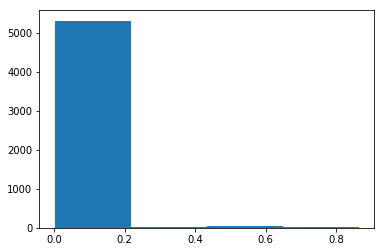

In [153]:
plt.hist(pred_probs, bins=4)
plt.show()

In [154]:
for i in np.arange(0,0.5,0.05):
    y_pred = grid_rf.predict_proba(X_train)[:, 1] > i
    print("")
    print("Metrics")
    print("")
    print(confusion_metrics(y_train, y_pred))

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics



NameError: name 'confusion_matrix' is not defined

#### Feature Importances

In [155]:
def plot_top_k_feature_importances_pipe(feature_names, coefs, k): 

    # sort 
    args = abs(coefs).argsort()[::-1][:k]    
    # get coefs 
    top_k_coefs = coefs[args]    
    # get column names
    colnames = feature_names[args]
    # plot 
    plt.barh(range(k), top_k_coefs, align='center') 
    plt.yticks(np.arange(k), colnames) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, k)
    plt.show()

In [156]:
 grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names()

array(['x0_html_files/CMS_2014_0115_0059.pdf',
       'x0_html_files/CMS_2014_0115_0076.pdf',
       'x0_html_files/CMS_2014_0115_10379.pdf',
       'x0_html_files/CMS_2014_0115_10593.pdf',
       'x0_html_files/CMS_2014_0115_11997.pdf',
       'x0_html_files/CMS_2014_0115_12304.pdf',
       'x0_html_files/CMS_2014_0115_12451.pdf',
       'x0_html_files/CMS_2014_0115_12505.pdf',
       'x0_html_files/CMS_2014_0115_12528.pdf',
       'x0_html_files/CMS_2014_0115_12572.pdf',
       'x0_html_files/CMS_2014_0115_12762.pdf',
       'x0_html_files/CMS_2014_0115_12895.pdf',
       'x0_html_files/CMS_2014_0115_12912.pdf',
       'x0_html_files/CMS_2014_0115_12938.pdf',
       'x0_html_files/CMS_2014_0115_13028.pdf',
       'x0_html_files/CMS_2014_0115_13111.pdf',
       'x0_html_files/CMS_2014_0115_13129.pdf',
       'x0_html_files/CMS_2014_0115_13162.pdf',
       'x0_html_files/CMS_2014_0115_13164.pdf',
       'x0_html_files/CMS_2014_0115_13166.pdf',
       'x0_html_files/CMS_2014_0115_13182.

In [157]:
grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[2][1].named_steps['count_vect'].get_feature_names()


['0938as50',
 '10',
 '1020',
 '10th',
 '10u200b',
 '11',
 '11009u200b',
 '1100u200b',
 '1104',
 '11042',
 '111',
 '1118',
 '113',
 '113cv01210',
 '115',
 '1171',
 '1174u200b',
 '12',
 '125',
 '1275',
 '12866',
 '13',
 '1301',
 '1310',
 '133',
 '134',
 '1379',
 '1396u2b3',
 '13pdf',
 '14',
 '147',
 '147130a1iv',
 '147131',
 '1486u200b',
 '14u200b',
 '15',
 '150',
 '152',
 '1534',
 '15th',
 '15u200b',
 '16',
 '16u200b',
 '17',
 '17745',
 '1776',
 '178',
 '179318',
 '17u200b',
 '18',
 '18023c2',
 '1875',
 '18u200b',
 '19',
 '190119',
 '1973',
 '1976',
 '1980s',
 '1986',
 '1987',
 '1993',
 '1995',
 '1996',
 '1998u200b',
 '1999',
 '19th',
 '19u200b',
 '1u200b',
 '20',
 '200',
 '20002',
 '20004',
 '20005',
 '2000bb',
 '2000bb1b2',
 '2000bbb1',
 '20017',
 '20036',
 '2004',
 '2005',
 '201',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '20141',
 '2015',
 '2016',
 '2017',
 '2017u200b',
 '20201',
 '20210',
 '2022964012',
 '2026679070',
 '2027',
 '205',
 '20u200b',
 '21',
 '21224',
 '21244',
 '212441850',
 '212448016',
 '21exhibit',
 '21u200b',
 '22',
 '22314',
 '22u200b',
 '23',
 '2318',
 '23u200b',
 '24',
 '24u200b',
 '25',
 '2590',
 '25u200b',
 '26',
 '27',
 '2713',
 '2751',
 '2769',
 '2775',
 '27u200b',
 '28',
 '280311',
 '28u200b',
 '29',
 '2969',
 '2996fb',
 '2d',
 '2u200b',
 '30',
 '300a7',
 '300gg22b2ci',
 '30dayu200b',
 '30u200b',
 '31',
 '312',
 '31u200b',
 '32',
 '3211',
 '32u200b',
 '33',
 '34',
 '34u200b',
 '35',
 '356_amcu_dflaauthcheckdampdf',
 '356_bsac_christian_legal_socpdf',
 '35see',
 '35u200b',
 '36',
 '37',
 '377',
 '37u200b',
 '38',
 '38u200b',
 '39',
 '39870',
 '39888',
 '39j',
 '3u200b',
 '40',
 '406',
 '40u200b',
 '41',
 '410',
 '42',
 '42u200b',
 '43',
 '44',
 '445g',
 '44u200b',
 '45',
 '45u200b',
 '46',
 '46u200b',
 '47',
 '47u200b',
 '48u200b',
 '49',
 '49u200b',
 '50',
 '500',
 '504',
 '51118',
 '51127',
 '52u200b',
 '53su200b',
 '53u200b',
 '54',
 '542',
 '5498152713e1',
 '54u200b',
 '55u200b',
 '566775',
 '573',
 '5u200b',
 '6033a1',
 '6033a3ai',
 '6221',
 '64',
 '655',
 '66',
 '6th',
 '6u200b',
 '70',
 '700',
 '703',
 '7036848007',
 '73',
 '74',
 '75',
 '7500',
 '77',
 '7723538',
 '78',
 '79',
 '7u200b',
 '8001',
 '8010',
 '8013',
 '8016',
 '82',
 '8403',
 '850',
 '8617788',
 '88',
 '89',
 '8u200b',
 '8u200bu200b',
 '9010',
 '915',
 '94439',
 '9940p',
 '9thu200b',
 '9u200b',
 'abbey',
 'ability',
 'abilityu200b',
 'able',
 'abortifacient',
 'abortifacients',
 'abortion',
 'abortioninducing',
 'abortions',
 'about',
 'above',
 'absent',
 'aca',
 'acas',
 'acceptable',
 'access',
 'accessed',
 'accessmatters',
 'accessu200b',
 'accommodated',
 'accommodation',
 'accommodation39',
 'accommodation6',
 'accommodationand',
 'accommodations',
 'accommodationsu200b',
 'accompanied',
 'accordance',
 'according',
 'accordingly',
 'account',
 'accountability',
 'accumulatedu200b',
 'acetate',
 'achieve',
 'achievement',
 'achieving',
 'acknowledged',
 'acknowledging',
 'aclu',
 'aclus',
 'acnm',
 'across',
 'acrossu200b',
 'act',
 'act47',
 'acting',
 'actingu200b',
 'action',
 'actions',
 'active',
 'actively',
 'activeu200b',
 'activities',
 'activity',
 'activity24',
 'acts',
 'actual',
 'actuarial',
 'acutely',
 'adam',
 'adara',
 'added',
 'addition',
 'additional',
 'additionally',
 'address',
 'addressed',
 'addressing',
 'addressu200b',
 'adds',
 'adequacy',
 'adequate',
 'adf',
 'adheres',
 'adjustment',
 'administer',
 'administration',
 'administrationapproved',
 'administrations',
 'administrative',
 'administrativeu200b',
 'administrator',
 'administrators',
 'adolescent',
 'adolescentu200b',
 'adopt',
 'adopted',
 'advanced',
 'advancing',
 'advantage',
 'advise',
 'advocacy',
 'advocacya',
 'affairs',
 'affect',
 'affected',
 'affiliate',
 'affiliated',
 'affiliates',
 'affiliation',
 'affirm',
 'affordable',
 'affording',
 'after',
 'again',
 'against',
 'agazineu200b',
 'agencies',
 'agency',
 'agents',
 'agosto',
 'agree',
 'agreed',
 'agreement',
 'aids',
 'aims',
 'airlinesu200b',
 'airports',
 

In [158]:
grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[1][1]

Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True))])

In [159]:
cat_cols = grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names()
num_cols = np.asarray(grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[0][2])
txt_cols = grid_rf.best_estimator_.named_steps['preprocessor'].transformers_[2][1].named_steps['count_vect'].get_feature_names()

one_hot_feature_names_rf = np.concatenate((cat_cols, num_cols,txt_cols), axis = None)

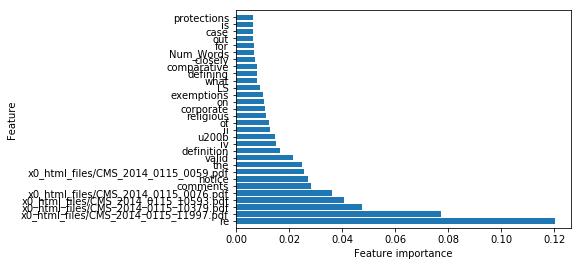

In [161]:
plot_top_k_feature_importances_pipe(one_hot_feature_names_rf, grid_rf.best_estimator_.named_steps['classifier'].feature_importances_, 30)

### 3. Evaluate on Test Set

In [135]:
grid_rf.score(X_test,y_test)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9139876164009556

In [136]:
y_pred = grid_rf.predict(X_test)

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Other Metrics

In [165]:
metrics(y_test, y_pred)

In [138]:
print("Test Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Test F1 score: {:.2f}".format(f1_score(y_test, y_pred)))

Test Accuracy score: 0.98
Test F1 score: 0.26


### Confustion metrics , recall, precision

In [139]:
confusion = confusion_matrix(y_test, y_pred)
#confusion = confusion_matrix(y_test, rf_probs)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[2278    1]
 [  38    7]]


In [140]:
precision_test = TP / float(TP + FP)
print("Precision for test %.2f" % precision_test)

Precision for test 0.88


In [141]:
Recall_test = TP / float(TP + FN)

print("Recall for test %.2f" % Recall_test)

Recall for test 0.16


In [382]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n         0.0       0.98      1.00      0.99      2279\n         1.0       0.91      0.22      0.36        45\n\n   micro avg       0.98      0.98      0.98      2324\n   macro avg       0.95      0.61      0.67      2324\nweighted avg       0.98      0.98      0.98      2324\n'

#### Thresholding

In [212]:
pred_probs = grid_rf.predict_proba(X_test)[:, 1] 

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


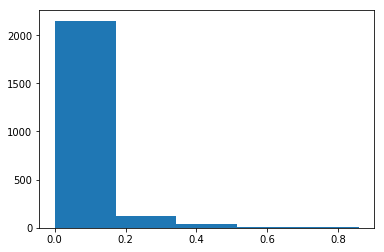

In [213]:
plt.hist(pred_probs, bins=5)
plt.show()

In [170]:
y_pred_probs = grid_rf.predict_proba(X_test)[:, 1]

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Text(0, 0.5, '%')

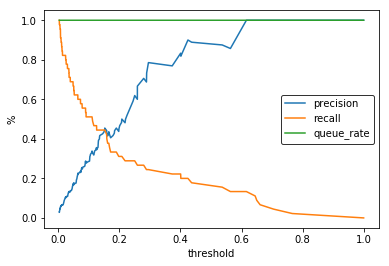

In [171]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs) 
thresholds = np.append(thresholds, 1) 
queue_rate = [] 
for threshold in thresholds: 
    queue_rate.append((y_pred >= threshold).mean()) 
plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2]) 
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('threshold') 
plt.ylabel('%')

In [215]:
for i in np.arange(0,0.5,0.01):
    y_pred = grid_rf.predict_proba(X_test)[:, 1] > i
    print("")
    print("Metrics")
    print("Threshold =", i)
    print("")
    print(metrics(y_test, y_pred))
    print(confusion_metrics(y_test, y_pred))

C:\Users\Gayani\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.0

Accuracy score: 0.06


NameError: name 'f1_score' is not defined

### Precision - Recall Curve

Average precision-recall score RF: 0.41661417516211


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.42')

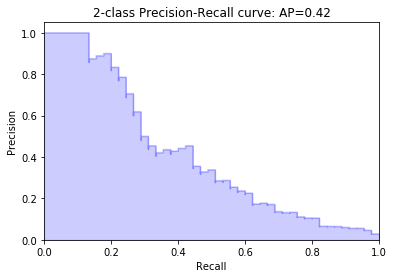

In [173]:
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


average_precision = average_precision_score(y_test, y_pred_probs)

print('Average precision-recall score RF: {}'.format(average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


##### EXTRA: GridSearch With Wrapper with refit = recall score

In [218]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
} 

In [145]:
def grid_search_wrapper(refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(pipe_rf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')
grid_search_clf.fit(X_train, y_train)


In [ ]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score'
         ]].head(10)

In [ ]:
y_pred = grid_search_clf.best_estimator_.predict(X_train)
y_pred_class = grid_search_clf.best_estimator_.predict(X_test)

In [ ]:
print("Test Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred_class)))
print("Test F1 score: {:.2f}".format(f1_score(y_test, y_pred_class)))

In [ ]:
print("Train Accuracy score: {:.2f}".format(accuracy_score(y_train, y_pred)))
print("Train F1 score: {:.2f}".format(f1_score(y_train, y_pred)))

In [ ]:
print (classification_report(y_test, y_pred_class))